In [14]:
# Basics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

# Metrics
from sklearn.metrics import accuracy_score, f1_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import itertools
import time
import random
import logging

In [15]:
SEED = 67

def seeds():
    #random.seed(SEED)
    #np.random.seed(SEED)
    #torch.manual_seed(SEED)
    #torch.cuda.manual_seed(SEED)
    #torch.cuda.manual_seed_all(SEED)
    #torch.use_deterministic_algorithms(True)
    #torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    pl.seed_everything(SEED, workers=True)

seeds()

Seed set to 67


In [16]:
class ECGDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file, header=0)  # read column names
        # Convert all columns to numeric, coerce errors
        df = df.apply(pd.to_numeric, errors='coerce')
        df = df.dropna()
        data = df.values
        self.X = torch.tensor(data[:, :-1], dtype=torch.float32)  # all features except last column
        self.y = torch.tensor(data[:, -1], dtype=torch.long)       # last column as label

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # GRU expects (seq_len, features), so add feature dimension
        return self.X[idx].unsqueeze(-1), self.y[idx]


In [17]:
class ECGDataModule(pl.LightningDataModule):
    def __init__(self, train_csv, val_csv, test_csv, batch_size=64):
        super().__init__()
        self.train_csv = train_csv
        self.val_csv = val_csv
        self.test_csv = test_csv
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = ECGDataset(self.train_csv)
        self.val_dataset = ECGDataset(self.val_csv)
        self.test_dataset = ECGDataset(self.test_csv)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)


In [18]:
class GRUClassifier(pl.LightningModule):
    def __init__(self, input_size=1, hidden_size=32, output_size=5, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        # store test outputs
        self.test_preds = []
        self.test_targets = []
        self.test_acc = None
        self.test_f1 = None

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # last time step
        out = self.fc(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())
        f1 = f1_score(y.cpu(), preds.cpu(), average='macro')
        self.log_dict({'val_loss': loss, 'val_acc': acc, 'val_f1': f1}, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        self.test_preds.append(preds.cpu())
        self.test_targets.append(y.cpu())

    def on_test_epoch_end(self):
        preds = torch.cat(self.test_preds)
        targets = torch.cat(self.test_targets)
        acc = accuracy_score(targets, preds)
        f1 = f1_score(targets, preds, average='macro')
        print(f"Test Accuracy: {acc:.4f}, Test F1-score: {f1:.4f}")
        
        # Store for logging
        self.test_acc = acc
        self.test_f1 = f1
        
        # Clear lists for future tests
        self.test_preds = []
        self.test_targets = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


In [19]:
# Correct CSV paths
train_csv = 'dataset/data/processed/train_split.csv'
val_csv   = 'dataset/data/processed/val_split.csv'
test_csv  = 'dataset/data/processed/test_split.csv'

# Hyperparameters
batch_size = 64
hidden_size = 32
lr = 1e-3
num_epochs = 10
output_size = 5  # ECG5000 has 5 classes

# Data
data_module = ECGDataModule(train_csv, val_csv, test_csv, batch_size=batch_size)

# Model
model = GRUClassifier(input_size=1, hidden_size=hidden_size, output_size=output_size, lr=lr)

# Callbacks
checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max')

# Trainer
trainer = pl.Trainer(max_epochs=num_epochs, 
                     callbacks=[checkpoint_callback], 
                     accelerator='auto')


In [20]:
start_time = time.time()
trainer.fit(model, datamodule=data_module)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")


Epoch 9: 100%|██████████| 47/47 [00:04<00:00,  9.65it/s, v_num=29, train_loss=0.277, val_loss=0.320, val_acc=0.923, val_f1=0.497]
Training time: 43.27 seconds


In [21]:
trainer.test(model, datamodule=data_module)


Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 59.41it/s]


[{}]

In [22]:
baseline_metrics = {
    'Model': 'GRU 1L',
    'Hidden Size': model.hparams.hidden_size,
    'Layers': 1,
    'Epochs': num_epochs,
    'Train Time (s)': round(training_time, 2),
    'Test Accuracy': round(model.test_acc, 4),
    'Test F1': round(model.test_f1, 4)
}

baseline_df = pd.DataFrame([baseline_metrics])
baseline_df


,Model,Hidden Size,Layers,Epochs,Train Time (s),Test Accuracy,Test F1
0,GRU 1L,32,1,10,43.27,0.918,0.3774


In [23]:
# Weight initialization
def init_weights(model, init_type='default'):
    for name, param in model.named_parameters():
        if 'weight' in name:
            if init_type == 'xavier':
                nn.init.xavier_uniform_(param)
            elif init_type == 'kaiming':
                nn.init.kaiming_uniform_(param, nonlinearity='relu')
            # default -> leave as is

In [24]:
# --- Helper maps for activation and optimizer ---
def get_activation(name: str):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "gelu":
        return nn.GELU()
    elif name == "leakyrelu":
        return nn.LeakyReLU()
    elif name == "tanh":
        return nn.Tanh()
    else:
        raise ValueError(f"Unsupported activation: {name}")

def get_optimizer(name: str, parameters, lr: float):
    name = name.lower()
    if name == "adam":
        return torch.optim.Adam(parameters, lr=lr)
    elif name == "adamw":
        return torch.optim.AdamW(parameters, lr=lr)
    elif name == "rmsprop":
        return torch.optim.RMSprop(parameters, lr=lr)
    elif name == "sgd":
        return torch.optim.SGD(parameters, lr=lr, momentum=0.9)
    elif name == "adagrad":
        return torch.optim.Adagrad(parameters, lr=lr)
    elif name == "nadam":
        return torch.optim.NAdam(parameters, lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {name}")


# --- Model Definition ---
class GRUClassifierGrid(pl.LightningModule):
    def __init__(self, input_size=1, hidden_size=32, output_size=5,
                 activation='relu', dropout=0.0, lr=1e-3,
                 optimizer_name='adam', weight_init='default'):
        super().__init__()
        self.save_hyperparameters()
        self.activation_name = activation
        self.activation_fn = get_activation(activation)
        self.lr = lr
        self.optimizer_name = optimizer_name

        # GRU + classifier head
        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.fc = nn.Linear(hidden_size, output_size)

        # Optional weight initialization
        if weight_init != 'default':
            init_weights(self, weight_init)

        # Buffers for test metrics
        self.test_preds = []
        self.test_targets = []

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # last timestep
        out = self.activation_fn(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())
        f1 = f1_score(y.cpu(), preds.cpu(), average='macro')
        self.log_dict({'val_loss': loss, 'val_acc': acc, 'val_f1': f1}, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        self.test_preds.append(preds.cpu())
        self.test_targets.append(y.cpu())

    def on_test_epoch_end(self):
        preds = torch.cat(self.test_preds)
        targets = torch.cat(self.test_targets)
        self.test_acc = accuracy_score(targets, preds)
        self.test_f1 = f1_score(targets, preds, average='macro')
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        # Use the helper mapping function
        return get_optimizer(self.optimizer_name, self.parameters(), self.lr)


In [25]:
grid_params = {
    'hidden_size': [16, 24, 32, 48, 64, 96],
    'activation': ['relu'],
    'optimizer_name': ['adam'],
    'lr': [5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
    'dropout': [0.2],
    'weight_init': ['default']
}

In [26]:
# Suppress PyTorch Lightning info/warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# Store results
results = []

# Cartesian product of all parameter combinations
all_combinations = list(itertools.product(
    grid_params['hidden_size'],
    grid_params['activation'],
    grid_params['optimizer_name'],
    grid_params['lr'],
    grid_params['dropout'],
    grid_params['weight_init']
))

print(f"Total experiments: {len(all_combinations)}\n")

for i, (hidden_size, activation, optimizer_name, lr, dropout, weight_init) in enumerate(all_combinations):

    seeds()

    print(f"Experiment {i+1}/{len(all_combinations)}: "
          f"hidden_size={hidden_size}, activation={activation}, optimizer={optimizer_name}, "
          f"lr={lr}, dropout={dropout}, weight_init={weight_init}")

    # Initialize model with current parameters
    model = GRUClassifierGrid(
        hidden_size=hidden_size,
        activation=activation,
        optimizer_name=optimizer_name,
        lr=lr,
        dropout=dropout,
        weight_init=weight_init,
        output_size=5
    )

    # Create a fresh Trainer per experiment
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator='auto',
        logger=False,
        enable_checkpointing=False,
        enable_model_summary=False,
        enable_progress_bar=True,   # shows epoch progress
        log_every_n_steps=50        # optional: reduce batch-level logging
    )

    # Train
    start_time = time.time()
    trainer.fit(model, datamodule=data_module)
    train_time = time.time() - start_time

    # Test
    trainer.test(model, datamodule=data_module)

    # Print only final test metrics
    print(f"--> Test Accuracy: {model.test_acc:.4f}, Test F1: {model.test_f1:.4f}, Train Time: {train_time:.2f}s\n")

    # Save metrics
    results.append({
        'hidden_size': hidden_size,
        'activation': activation,
        'optimizer': optimizer_name,
        'lr': lr,
        'dropout': dropout,
        'weight_init': weight_init,
        'train_time_s': round(train_time, 2),
        'test_acc': round(model.test_acc, 4),
        'test_f1': round(model.test_f1, 4)
    })

# Convert to DataFrame and export
results_df = pd.DataFrame(results)
results_df.to_csv('gru_grid_search_results.csv', index=False)
print("Grid search complete! Results saved to 'gru_grid_search_results.csv'")

Seed set to 67


Total experiments: 36

Experiment 1/36: hidden_size=16, activation=relu, optimizer=adam, lr=5e-05, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 80.70it/s]

Seed set to 67



--> Test Accuracy: 0.3520, Test F1: 0.1043, Train Time: 23.41s

Experiment 2/36: hidden_size=16, activation=relu, optimizer=adam, lr=0.0001, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 96.27it/s] 

Seed set to 67



--> Test Accuracy: 0.7970, Test F1: 0.3278, Train Time: 29.74s

Experiment 3/36: hidden_size=16, activation=relu, optimizer=adam, lr=0.0005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 99.64it/s] 

Seed set to 67



--> Test Accuracy: 0.9010, Test F1: 0.3698, Train Time: 28.34s

Experiment 4/36: hidden_size=16, activation=relu, optimizer=adam, lr=0.001, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 90.85it/s] 

Seed set to 67



--> Test Accuracy: 0.9100, Test F1: 0.3739, Train Time: 27.66s

Experiment 5/36: hidden_size=16, activation=relu, optimizer=adam, lr=0.005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 93.90it/s]

Seed set to 67



--> Test Accuracy: 0.9000, Test F1: 0.3884, Train Time: 28.24s

Experiment 6/36: hidden_size=16, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 81.11it/s]

Seed set to 67



--> Test Accuracy: 0.9200, Test F1: 0.3962, Train Time: 27.81s

Experiment 7/36: hidden_size=24, activation=relu, optimizer=adam, lr=5e-05, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 61.54it/s]

Seed set to 67



--> Test Accuracy: 0.3820, Test F1: 0.1291, Train Time: 33.35s

Experiment 8/36: hidden_size=24, activation=relu, optimizer=adam, lr=0.0001, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 64.78it/s]

Seed set to 67



--> Test Accuracy: 0.8650, Test F1: 0.3533, Train Time: 33.23s

Experiment 9/36: hidden_size=24, activation=relu, optimizer=adam, lr=0.0005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 77.49it/s]

Seed set to 67



--> Test Accuracy: 0.9000, Test F1: 0.3694, Train Time: 30.66s

Experiment 10/36: hidden_size=24, activation=relu, optimizer=adam, lr=0.001, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 69.83it/s]

Seed set to 67



--> Test Accuracy: 0.9000, Test F1: 0.3694, Train Time: 30.53s

Experiment 11/36: hidden_size=24, activation=relu, optimizer=adam, lr=0.005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 77.87it/s]

Seed set to 67



--> Test Accuracy: 0.9070, Test F1: 0.3727, Train Time: 32.07s

Experiment 12/36: hidden_size=24, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 67.65it/s]

Seed set to 67



--> Test Accuracy: 0.9170, Test F1: 0.4147, Train Time: 32.59s

Experiment 13/36: hidden_size=32, activation=relu, optimizer=adam, lr=5e-05, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 45.96it/s]

Seed set to 67



--> Test Accuracy: 0.8380, Test F1: 0.3428, Train Time: 48.35s

Experiment 14/36: hidden_size=32, activation=relu, optimizer=adam, lr=0.0001, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 45.16it/s]

Seed set to 67



--> Test Accuracy: 0.8770, Test F1: 0.3589, Train Time: 50.00s

Experiment 15/36: hidden_size=32, activation=relu, optimizer=adam, lr=0.0005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 40.69it/s]

Seed set to 67



--> Test Accuracy: 0.9050, Test F1: 0.3717, Train Time: 51.62s

Experiment 16/36: hidden_size=32, activation=relu, optimizer=adam, lr=0.001, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 44.69it/s]

Seed set to 67



--> Test Accuracy: 0.9180, Test F1: 0.3775, Train Time: 55.04s

Experiment 17/36: hidden_size=32, activation=relu, optimizer=adam, lr=0.005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 45.29it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5455, Train Time: 55.29s

Experiment 18/36: hidden_size=32, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 42.99it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5428, Train Time: 52.98s

Experiment 19/36: hidden_size=48, activation=relu, optimizer=adam, lr=5e-05, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.55it/s]

Seed set to 67



--> Test Accuracy: 0.8830, Test F1: 0.3624, Train Time: 59.93s

Experiment 20/36: hidden_size=48, activation=relu, optimizer=adam, lr=0.0001, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.15it/s]

Seed set to 67



--> Test Accuracy: 0.8960, Test F1: 0.3675, Train Time: 58.08s

Experiment 21/36: hidden_size=48, activation=relu, optimizer=adam, lr=0.0005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 31.14it/s]

Seed set to 67



--> Test Accuracy: 0.9200, Test F1: 0.3787, Train Time: 56.86s

Experiment 22/36: hidden_size=48, activation=relu, optimizer=adam, lr=0.001, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.89it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4812, Train Time: 57.72s

Experiment 23/36: hidden_size=48, activation=relu, optimizer=adam, lr=0.005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.86it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5114, Train Time: 58.70s

Experiment 24/36: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.44it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5504, Train Time: 61.30s

Experiment 25/36: hidden_size=64, activation=relu, optimizer=adam, lr=5e-05, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.10it/s]

Seed set to 67



--> Test Accuracy: 0.8780, Test F1: 0.3604, Train Time: 64.03s

Experiment 26/36: hidden_size=64, activation=relu, optimizer=adam, lr=0.0001, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.14it/s]

Seed set to 67



--> Test Accuracy: 0.8990, Test F1: 0.3689, Train Time: 63.30s

Experiment 27/36: hidden_size=64, activation=relu, optimizer=adam, lr=0.0005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.60it/s]

Seed set to 67



--> Test Accuracy: 0.9240, Test F1: 0.4140, Train Time: 63.29s

Experiment 28/36: hidden_size=64, activation=relu, optimizer=adam, lr=0.001, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.76it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4720, Train Time: 62.34s

Experiment 29/36: hidden_size=64, activation=relu, optimizer=adam, lr=0.005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.89it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5225, Train Time: 61.72s

Experiment 30/36: hidden_size=64, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.58it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5098, Train Time: 63.44s

Experiment 31/36: hidden_size=96, activation=relu, optimizer=adam, lr=5e-05, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 25.30it/s]

Seed set to 67



--> Test Accuracy: 0.8930, Test F1: 0.3662, Train Time: 69.44s

Experiment 32/36: hidden_size=96, activation=relu, optimizer=adam, lr=0.0001, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 25.34it/s]

Seed set to 67



--> Test Accuracy: 0.9020, Test F1: 0.3701, Train Time: 71.11s

Experiment 33/36: hidden_size=96, activation=relu, optimizer=adam, lr=0.0005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 25.18it/s]

Seed set to 67



--> Test Accuracy: 0.9340, Test F1: 0.4799, Train Time: 68.63s

Experiment 34/36: hidden_size=96, activation=relu, optimizer=adam, lr=0.001, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 25.87it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.4804, Train Time: 65.14s

Experiment 35/36: hidden_size=96, activation=relu, optimizer=adam, lr=0.005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 26.12it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5251, Train Time: 64.26s

Experiment 36/36: hidden_size=96, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 25.69it/s]
--> Test Accuracy: 0.9140, Test F1: 0.4088, Train Time: 64.04s

Grid search complete! Results saved to 'gru_grid_search_results.csv'


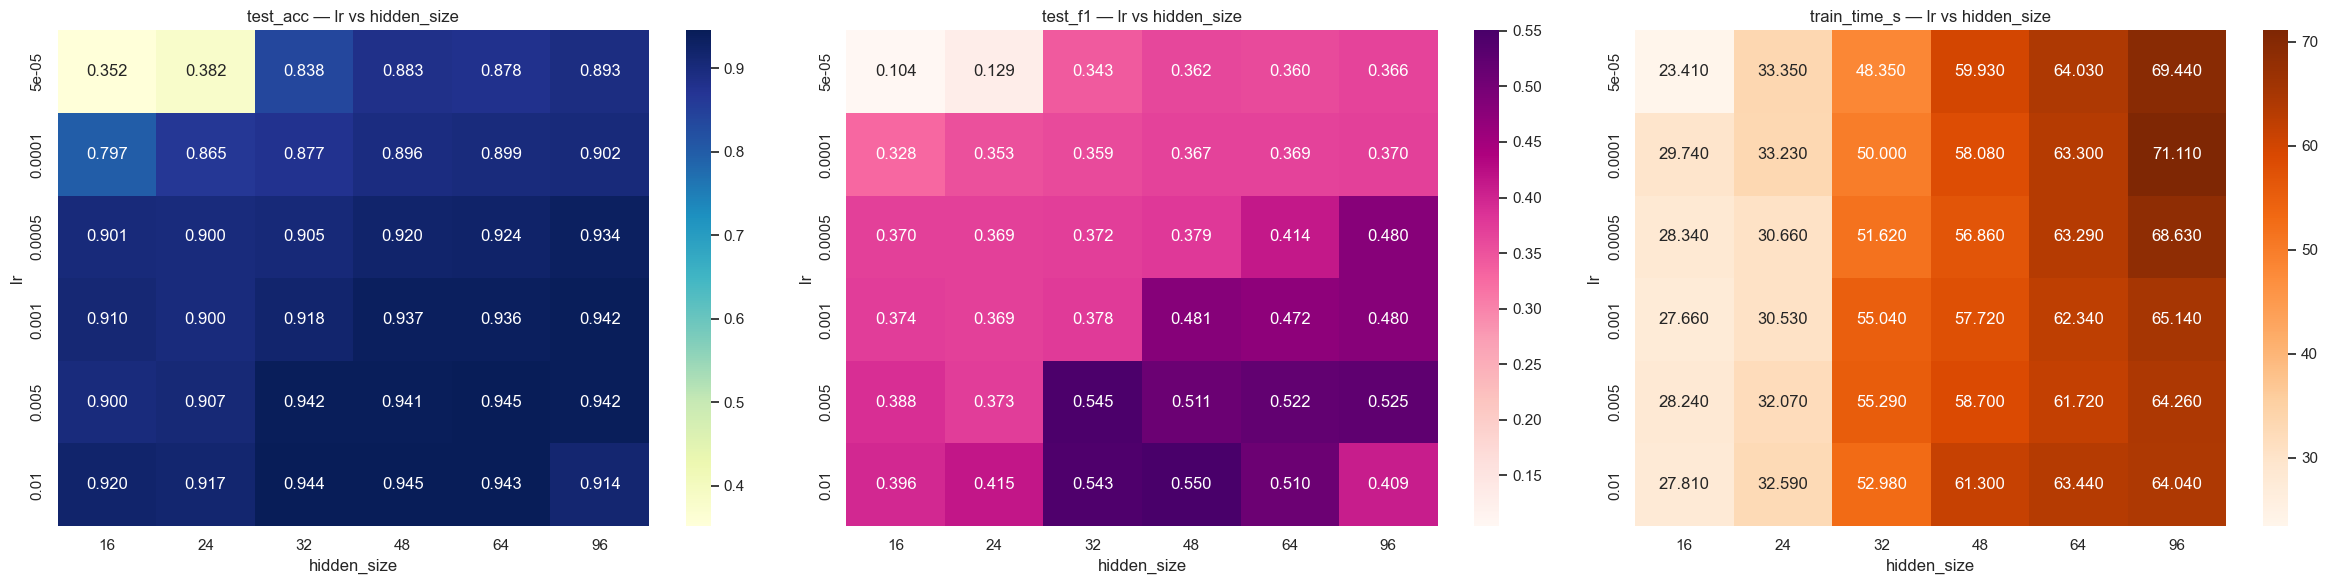

In [90]:
# Load the CSV results from your grid search
df = pd.read_csv('gru_grid_search_results.csv')

metrics = {
        "test_acc": "YlGnBu",
        "test_f1": "RdPu",
        "train_time_s": "Oranges"
    }

def plots(p1, p2):
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    for ax, (metric, cmap) in zip(axes, metrics.items()):
        pivot = df.pivot_table(values=metric, index=p1, columns=p2, aggfunc="mean")
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap=cmap, ax=ax)
        ax.set_title(f"{metric} — {p1} vs {p2}")
        ax.set_xlabel(p2)
        ax.set_ylabel(p1)

    plt.tight_layout()
    plt.show()

plots("lr", "hidden_size")



## **Learning Rate vs Hidden Size**

### **1. Test Accuracy Patterns**

* Accuracy generally **increases with hidden size**, with the largest gains seen from 16→32 units. Beyond 48 units, improvements are smaller, indicating diminishing returns.
* For very small learning rates (5e-5), performance is poor, especially for smaller hidden sizes (16–24).
* Moderate to slightly high learning rates (0.0005–0.01) combined with mid-to-large hidden sizes (32–96) yield the **highest accuracies (0.942–0.945)**.
* Extremely high learning rates (0.01) can slightly reduce accuracy at the largest hidden sizes (e.g., 96 units → 0.914), suggesting possible overshooting.

**Conclusion:**
Optimal range is **hidden size 32–64 and learning rate 0.0005–0.005**. Very small or very high learning rates harm performance, especially with small hidden sizes.

### **2. F1 Score Patterns**

* F1 mirrors accuracy trends but highlights class-wise performance differences more clearly.
* Small hidden sizes + low learning rates → poor F1 (<0.15–0.35).
* Best F1 values (~0.545–0.550) occur with **hidden sizes 32–64 and learning rates 0.005–0.01**, showing improved class balance.
* Extremely high hidden sizes (96) sometimes give slightly lower F1 at high learning rates (0.01 → 0.4088), indicating possible overfitting or instability.

**Conclusion:**
**F1 favors moderate hidden sizes (32–64) and moderate learning rates (0.0005–0.005)**, consistent with accuracy. Avoid extreme values for stable class-wise performance.

### **3. Training Time Patterns**

* Training time **increases with hidden size**, as expected.
* Learning rate has **little consistent effect on training time**, though smaller learning rates sometimes need slightly longer time to converge in early epochs.
* Largest models (96 units) take the longest (~64–71s), while the smallest (16 units) are fastest (~23–29s).

**Conclusion:**
Hidden size is the main driver of training cost. For practical purposes, **hidden sizes 32–48 strike a balance** between performance and training time.

### **Final Takeaway**

**Sweet spot for next hyperparameter tuning:** **Hidden size 32–48** and **learning rate 0.005–0.01**, providing high accuracy and F1 with moderate training time.


In [30]:
grid_params = {
    'hidden_size': [32, 36, 40, 44, 48],
    'activation': ['relu'],
    'optimizer_name': ['adam'],
    'lr': [0.005, 0.006, 0.0075, 0.009, 0.01],
    'dropout': [0.2],
    'weight_init': ['default']
}

In [31]:
# Suppress PyTorch Lightning info/warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# Store results
results = []

# Cartesian product of all parameter combinations
all_combinations = list(itertools.product(
    grid_params['hidden_size'],
    grid_params['activation'],
    grid_params['optimizer_name'],
    grid_params['lr'],
    grid_params['dropout'],
    grid_params['weight_init']
))

print(f"Total experiments: {len(all_combinations)}\n")

for i, (hidden_size, activation, optimizer_name, lr, dropout, weight_init) in enumerate(all_combinations):

    seeds()

    print(f"Experiment {i+1}/{len(all_combinations)}: "
          f"hidden_size={hidden_size}, activation={activation}, optimizer={optimizer_name}, "
          f"lr={lr}, dropout={dropout}, weight_init={weight_init}")

    # Initialize model with current parameters
    model = GRUClassifierGrid(
        hidden_size=hidden_size,
        activation=activation,
        optimizer_name=optimizer_name,
        lr=lr,
        dropout=dropout,
        weight_init=weight_init,
        output_size=5
    )

    # Create a fresh Trainer per experiment
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator='auto',
        logger=False,
        enable_checkpointing=False,
        enable_model_summary=False,
        enable_progress_bar=True,   # shows epoch progress
        log_every_n_steps=50        # optional: reduce batch-level logging
    )

    # Train
    start_time = time.time()
    trainer.fit(model, datamodule=data_module)
    train_time = time.time() - start_time

    # Test
    trainer.test(model, datamodule=data_module)

    # Print only final test metrics
    print(f"--> Test Accuracy: {model.test_acc:.4f}, Test F1: {model.test_f1:.4f}, Train Time: {train_time:.2f}s\n")

    # Save metrics
    results.append({
        'hidden_size': hidden_size,
        'activation': activation,
        'optimizer': optimizer_name,
        'lr': lr,
        'dropout': dropout,
        'weight_init': weight_init,
        'train_time_s': round(train_time, 2),
        'test_acc': round(model.test_acc, 4),
        'test_f1': round(model.test_f1, 4)
    })

# Convert to DataFrame and export
results_df = pd.DataFrame(results)
results_df.to_csv('gru_grid_search_results_2.csv', index=False)
print("Grid search complete! Results saved to 'gru_grid_search_results_2.csv'")

Seed set to 67


Total experiments: 25

Experiment 1/25: hidden_size=32, activation=relu, optimizer=adam, lr=0.005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 44.74it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5455, Train Time: 50.78s

Experiment 2/25: hidden_size=32, activation=relu, optimizer=adam, lr=0.006, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 46.39it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5492, Train Time: 51.09s

Experiment 3/25: hidden_size=32, activation=relu, optimizer=adam, lr=0.0075, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 45.64it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5438, Train Time: 52.70s

Experiment 4/25: hidden_size=32, activation=relu, optimizer=adam, lr=0.009, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 46.72it/s]

Seed set to 67



--> Test Accuracy: 0.9150, Test F1: 0.4241, Train Time: 55.20s

Experiment 5/25: hidden_size=32, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 43.70it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5428, Train Time: 54.60s

Experiment 6/25: hidden_size=36, activation=relu, optimizer=adam, lr=0.005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.98it/s]

Seed set to 67



--> Test Accuracy: 0.9280, Test F1: 0.4708, Train Time: 61.54s

Experiment 7/25: hidden_size=36, activation=relu, optimizer=adam, lr=0.006, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.32it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.4737, Train Time: 57.53s

Experiment 8/25: hidden_size=36, activation=relu, optimizer=adam, lr=0.0075, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.62it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.4614, Train Time: 56.90s

Experiment 9/25: hidden_size=36, activation=relu, optimizer=adam, lr=0.009, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.61it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5038, Train Time: 58.21s

Experiment 10/25: hidden_size=36, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.65it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.4330, Train Time: 58.70s

Experiment 11/25: hidden_size=40, activation=relu, optimizer=adam, lr=0.005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.95it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5134, Train Time: 61.18s

Experiment 12/25: hidden_size=40, activation=relu, optimizer=adam, lr=0.006, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.33it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5058, Train Time: 65.66s

Experiment 13/25: hidden_size=40, activation=relu, optimizer=adam, lr=0.0075, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.45it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4760, Train Time: 64.02s

Experiment 14/25: hidden_size=40, activation=relu, optimizer=adam, lr=0.009, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.52it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4854, Train Time: 62.91s

Experiment 15/25: hidden_size=40, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.86it/s]

Seed set to 67



--> Test Accuracy: 0.9320, Test F1: 0.5234, Train Time: 61.32s

Experiment 16/25: hidden_size=44, activation=relu, optimizer=adam, lr=0.005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.55it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5254, Train Time: 60.78s

Experiment 17/25: hidden_size=44, activation=relu, optimizer=adam, lr=0.006, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.99it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.5200, Train Time: 61.95s

Experiment 18/25: hidden_size=44, activation=relu, optimizer=adam, lr=0.0075, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.54it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.5071, Train Time: 61.86s

Experiment 19/25: hidden_size=44, activation=relu, optimizer=adam, lr=0.009, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.59it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5167, Train Time: 64.46s

Experiment 20/25: hidden_size=44, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.49it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.5105, Train Time: 66.26s

Experiment 21/25: hidden_size=48, activation=relu, optimizer=adam, lr=0.005, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.99it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5114, Train Time: 62.88s

Experiment 22/25: hidden_size=48, activation=relu, optimizer=adam, lr=0.006, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.88it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.4986, Train Time: 61.25s

Experiment 23/25: hidden_size=48, activation=relu, optimizer=adam, lr=0.0075, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.77it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5379, Train Time: 59.53s

Experiment 24/25: hidden_size=48, activation=relu, optimizer=adam, lr=0.009, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.66it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.5218, Train Time: 58.84s

Experiment 25/25: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.58it/s]
--> Test Accuracy: 0.9450, Test F1: 0.5504, Train Time: 59.78s

Grid search complete! Results saved to 'gru_grid_search_results_2.csv'


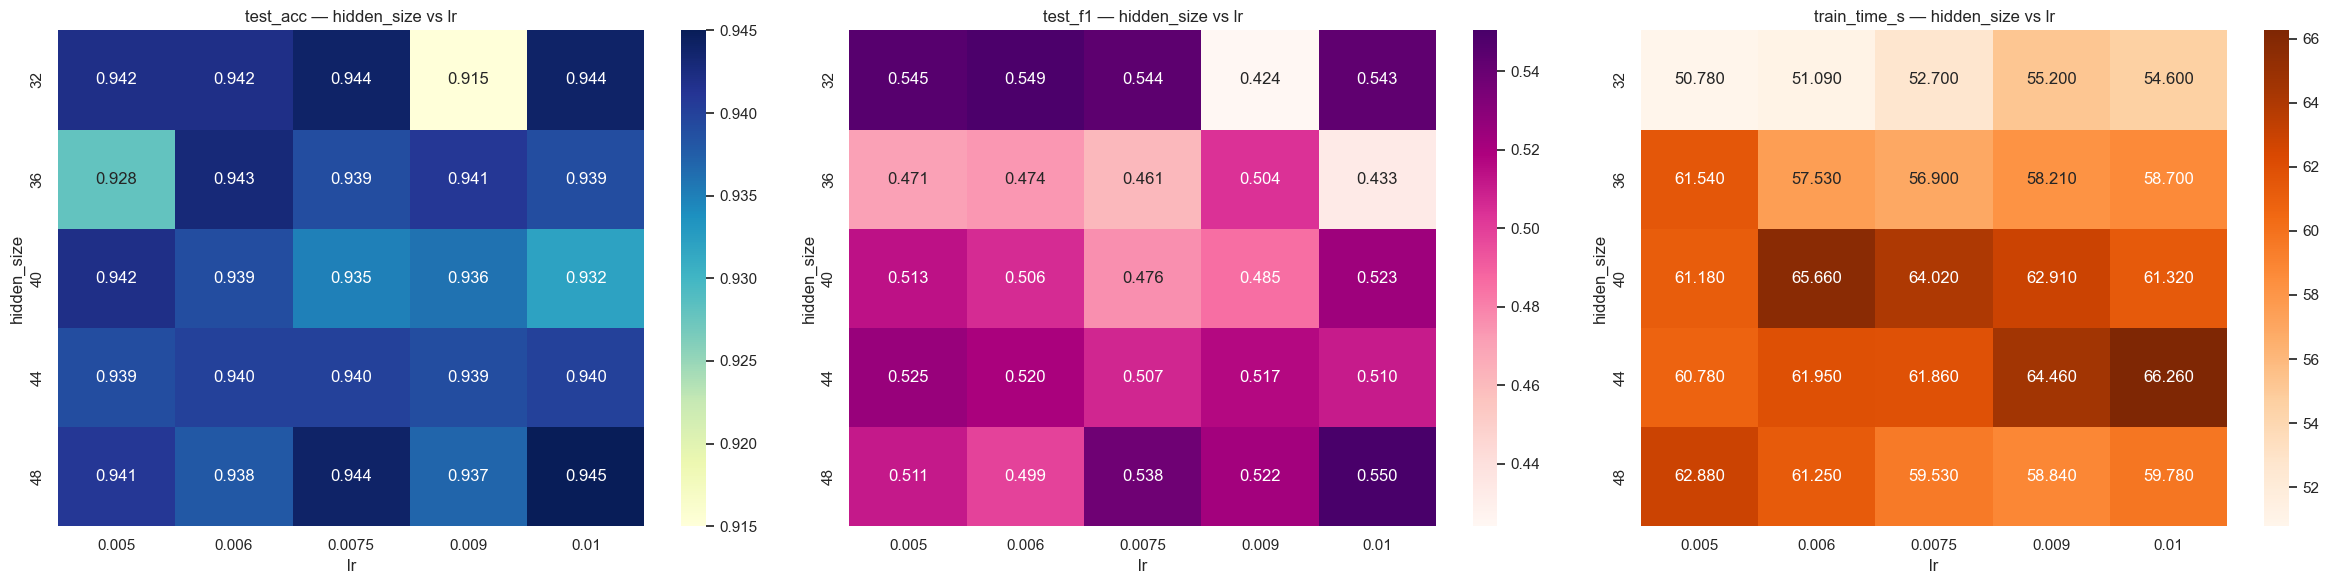

In [93]:
# Load the CSV results from your grid search
df = pd.read_csv('gru_grid_search_results_2.csv')

plots("hidden_size", "lr")

## **Learning Rate vs Hidden Size (Fine-tuning Range)**

### **1. Test Accuracy Patterns**

* Accuracy is **consistently high across most combinations**, mostly above 0.938, reflecting that the previous coarse grid already identified a good region.
* Hidden size **32–48** maintains strong performance, but some combinations (e.g., hidden size 36 at lr=0.005 → 0.928) show minor dips.
* Learning rates **0.005–0.01** generally give high accuracy across hidden sizes, though lr=0.009 with hidden size 32 drops to 0.915, suggesting sensitivity in some cases.

**Conclusion:**
Hidden size **32–48** remains robust; moderate learning rates **0.005–0.01** are good.

### **2. F1 Score Patterns**

* F1 trends roughly mirror accuracy, but provide insight into class-wise balance.
* Hidden size 32 gives the **highest F1 (0.545–0.549)** across lr=0.005–0.006.
* Hidden size 36 has lower F1 (~0.43–0.47), indicating less balanced predictions despite decent accuracy.
* Hidden size 48 achieves **peak F1 0.550** at lr=0.01, slightly higher than size 32 at same lr.

**Conclusion:**
F1 suggests hidden sizes **32 and 48** are best for class balance. Hidden size 36 underperforms in F1 despite moderate accuracy.

### **3. Training Time Patterns**

* Training time is **higher than in smaller grids**, ranging roughly 50–66s.
* Hidden size 32 is the fastest (~50–55s), while larger hidden sizes (40–48) take longer, up to ~66s.
* Learning rate has **minimal effect** on training time.

**Conclusion:**
For efficiency, hidden size **32** is preferred if training speed is a concern; hidden size 48 gives marginally higher F1 at cost of extra ~10–15s.

### **Overall Interpretation**

* **Best compromise:** hidden size **32** with learning rate **0.005–0.006** → high accuracy (0.942–0.944), strong F1 (0.545–0.549), and moderate training time (~50–52s).
* Hidden size 48 with lr=0.01 also gives excellent F1 but slightly longer training.

### **Final Takeaway:**

As a group, we decided that the training time difference was not significant, and therefore will, from this point on, use a fixed hidden size of 48 and learning rate of 0.01

In [35]:
grid_params = {
    'hidden_size': [48],
    'activation': ['relu', 'tanh', 'gelu', 'leakyrelu'],
    'optimizer_name': ['adagrad', 'adamw', 'nadam', 'sgd', 'adam', 'rmsprop'],
    'lr': [0.01],
    'dropout': [0.0, 0.1, 0.2, 0.3],
    'weight_init': ['default', 'xavier', 'kaiming', 'orthogonal']
}

In [36]:
# Suppress PyTorch Lightning info/warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# Store results
results = []

# Cartesian product of all parameter combinations
all_combinations = list(itertools.product(
    grid_params['hidden_size'],
    grid_params['activation'],
    grid_params['optimizer_name'],
    grid_params['lr'],
    grid_params['dropout'],
    grid_params['weight_init']
))

print(f"Total experiments: {len(all_combinations)}\n")

for i, (hidden_size, activation, optimizer_name, lr, dropout, weight_init) in enumerate(all_combinations):

    seeds()

    print(f"Experiment {i+1}/{len(all_combinations)}: "
          f"hidden_size={hidden_size}, activation={activation}, optimizer={optimizer_name}, "
          f"lr={lr}, dropout={dropout}, weight_init={weight_init}")

    # Initialize model with current parameters
    model = GRUClassifierGrid(
        hidden_size=hidden_size,
        activation=activation,
        optimizer_name=optimizer_name,
        lr=lr,
        dropout=dropout,
        weight_init=weight_init,
        output_size=5
    )

    # Create a fresh Trainer per experiment
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator='auto',
        logger=False,
        enable_checkpointing=False,
        enable_model_summary=False,
        enable_progress_bar=True,   # shows epoch progress
        log_every_n_steps=50        # optional: reduce batch-level logging
    )

    # Train
    start_time = time.time()
    trainer.fit(model, datamodule=data_module)
    train_time = time.time() - start_time

    # Test
    trainer.test(model, datamodule=data_module)

    # Print only final test metrics
    print(f"--> Test Accuracy: {model.test_acc:.4f}, Test F1: {model.test_f1:.4f}, Train Time: {train_time:.2f}s\n")

    # Save metrics
    results.append({
        'hidden_size': hidden_size,
        'activation': activation,
        'optimizer': optimizer_name,
        'lr': lr,
        'dropout': dropout,
        'weight_init': weight_init,
        'train_time_s': round(train_time, 2),
        'test_acc': round(model.test_acc, 4),
        'test_f1': round(model.test_f1, 4)
    })

# Convert to DataFrame and export
results_df = pd.DataFrame(results)
results_df.to_csv('gru_grid_search_results_3.csv', index=False)
print("Grid search complete! Results saved to 'gru_grid_search_results_3.csv'")

Seed set to 67


Total experiments: 384

Experiment 1/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.54it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4788, Train Time: 59.46s

Experiment 2/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.27it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4752, Train Time: 62.33s

Experiment 3/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.59it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.4864, Train Time: 62.41s

Experiment 4/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.31it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4788, Train Time: 61.65s

Experiment 5/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.95it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4744, Train Time: 59.20s

Experiment 6/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.83it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4690, Train Time: 58.49s

Experiment 7/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.55it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.4776, Train Time: 59.00s

Experiment 8/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.08it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4744, Train Time: 60.34s

Experiment 9/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.47it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4791, Train Time: 60.61s

Experiment 10/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.69it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4750, Train Time: 62.13s

Experiment 11/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.92it/s]

Seed set to 67



--> Test Accuracy: 0.9340, Test F1: 0.4609, Train Time: 62.33s

Experiment 12/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.83it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4791, Train Time: 62.24s

Experiment 13/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.88it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4784, Train Time: 60.44s

Experiment 14/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.30it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4665, Train Time: 58.93s

Experiment 15/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.59it/s]

Seed set to 67



--> Test Accuracy: 0.9330, Test F1: 0.4513, Train Time: 58.97s

Experiment 16/384: hidden_size=48, activation=relu, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.01it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4784, Train Time: 59.70s

Experiment 17/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.39it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5386, Train Time: 60.27s

Experiment 18/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.87it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.5172, Train Time: 62.82s

Experiment 19/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.76it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5673, Train Time: 62.42s

Experiment 20/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.01it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5386, Train Time: 61.64s

Experiment 21/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.97it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5497, Train Time: 60.00s

Experiment 22/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.97it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.4783, Train Time: 58.97s

Experiment 23/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.47it/s]

Seed set to 67



--> Test Accuracy: 0.9310, Test F1: 0.5037, Train Time: 59.99s

Experiment 24/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.68it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5497, Train Time: 58.86s

Experiment 25/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.77it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5339, Train Time: 60.89s

Experiment 26/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.65it/s]

Seed set to 67



--> Test Accuracy: 0.9470, Test F1: 0.5728, Train Time: 63.44s

Experiment 27/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.12it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5378, Train Time: 62.19s

Experiment 28/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.48it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5339, Train Time: 60.97s

Experiment 29/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.54it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5393, Train Time: 59.39s

Experiment 30/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.13it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.4961, Train Time: 58.04s

Experiment 31/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.18it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.5398, Train Time: 59.29s

Experiment 32/384: hidden_size=48, activation=relu, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.31it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5393, Train Time: 59.62s

Experiment 33/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.05it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5069, Train Time: 62.18s

Experiment 34/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.81it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5344, Train Time: 63.19s

Experiment 35/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.43it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5385, Train Time: 62.31s

Experiment 36/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.63it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5069, Train Time: 60.53s

Experiment 37/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 49.31it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5608, Train Time: 57.90s

Experiment 38/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 50.10it/s]

Seed set to 67



--> Test Accuracy: 0.9210, Test F1: 0.4611, Train Time: 31.89s

Experiment 39/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 46.81it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5497, Train Time: 31.21s

Experiment 40/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 51.52it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5608, Train Time: 31.50s

Experiment 41/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 53.74it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5452, Train Time: 31.11s

Experiment 42/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.79it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5759, Train Time: 49.04s

Experiment 43/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.54it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5460, Train Time: 60.20s

Experiment 44/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.79it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5452, Train Time: 61.25s

Experiment 45/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.95it/s]

Seed set to 67



--> Test Accuracy: 0.9180, Test F1: 0.3772, Train Time: 60.65s

Experiment 46/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.43it/s]

Seed set to 67



--> Test Accuracy: 0.9200, Test F1: 0.4442, Train Time: 60.13s

Experiment 47/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.82it/s]

Seed set to 67



--> Test Accuracy: 0.9340, Test F1: 0.5327, Train Time: 58.06s

Experiment 48/384: hidden_size=48, activation=relu, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.48it/s]

Seed set to 67



--> Test Accuracy: 0.9180, Test F1: 0.3772, Train Time: 58.43s

Experiment 49/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.05it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3707, Train Time: 58.71s

Experiment 50/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.18it/s]

Seed set to 67



--> Test Accuracy: 0.9080, Test F1: 0.3728, Train Time: 59.39s

Experiment 51/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.70it/s]

Seed set to 67



--> Test Accuracy: 0.9140, Test F1: 0.3759, Train Time: 61.01s

Experiment 52/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.80it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3707, Train Time: 61.40s

Experiment 53/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.34it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3707, Train Time: 60.54s

Experiment 54/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.90it/s]

Seed set to 67



--> Test Accuracy: 0.9050, Test F1: 0.3716, Train Time: 57.55s

Experiment 55/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.63it/s]

Seed set to 67



--> Test Accuracy: 0.9140, Test F1: 0.3759, Train Time: 57.95s

Experiment 56/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.30it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3707, Train Time: 58.22s

Experiment 57/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.83it/s]

Seed set to 67



--> Test Accuracy: 0.9020, Test F1: 0.3702, Train Time: 59.02s

Experiment 58/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.61it/s]

Seed set to 67



--> Test Accuracy: 0.9090, Test F1: 0.3733, Train Time: 59.65s

Experiment 59/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.80it/s]

Seed set to 67



--> Test Accuracy: 0.9110, Test F1: 0.3746, Train Time: 61.69s

Experiment 60/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.40it/s]

Seed set to 67



--> Test Accuracy: 0.9020, Test F1: 0.3702, Train Time: 62.56s

Experiment 61/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.32it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3707, Train Time: 61.76s

Experiment 62/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.98it/s]

Seed set to 67



--> Test Accuracy: 0.9080, Test F1: 0.3728, Train Time: 60.13s

Experiment 63/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.19it/s]

Seed set to 67



--> Test Accuracy: 0.9110, Test F1: 0.3746, Train Time: 58.42s

Experiment 64/384: hidden_size=48, activation=relu, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.17it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3707, Train Time: 58.23s

Experiment 65/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.33it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4728, Train Time: 58.72s

Experiment 66/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.04it/s]

Seed set to 67



--> Test Accuracy: 0.9460, Test F1: 0.5462, Train Time: 57.47s

Experiment 67/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.88it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.5440, Train Time: 62.24s

Experiment 68/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.35it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4728, Train Time: 62.93s

Experiment 69/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.02it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5280, Train Time: 62.20s

Experiment 70/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.92it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5324, Train Time: 60.65s

Experiment 71/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.25it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.5318, Train Time: 58.86s

Experiment 72/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.89it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5280, Train Time: 59.13s

Experiment 73/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.75it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5504, Train Time: 59.05s

Experiment 74/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.55it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.5086, Train Time: 59.38s

Experiment 75/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.29it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5442, Train Time: 62.03s

Experiment 76/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.86it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5504, Train Time: 61.69s

Experiment 77/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.65it/s]

Seed set to 67



--> Test Accuracy: 0.9330, Test F1: 0.4466, Train Time: 61.10s

Experiment 78/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.35it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4543, Train Time: 58.97s

Experiment 79/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.00it/s]

Seed set to 67



--> Test Accuracy: 0.9300, Test F1: 0.4901, Train Time: 57.71s

Experiment 80/384: hidden_size=48, activation=relu, optimizer=adam, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.08it/s]

Seed set to 67



--> Test Accuracy: 0.9330, Test F1: 0.4466, Train Time: 57.46s

Experiment 81/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.33it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5123, Train Time: 58.03s

Experiment 82/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.78it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5833, Train Time: 58.14s

Experiment 83/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.40it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.5736, Train Time: 61.42s

Experiment 84/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.01it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5123, Train Time: 61.35s

Experiment 85/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 31.17it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5467, Train Time: 61.03s

Experiment 86/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.28it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5724, Train Time: 59.43s

Experiment 87/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.37it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5743, Train Time: 58.39s

Experiment 88/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.18it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5467, Train Time: 57.98s

Experiment 89/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.29it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5344, Train Time: 59.01s

Experiment 90/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.89it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5310, Train Time: 58.84s

Experiment 91/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.04it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5511, Train Time: 61.14s

Experiment 92/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.61it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5344, Train Time: 61.04s

Experiment 93/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.48it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.5383, Train Time: 60.90s

Experiment 94/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.79it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5544, Train Time: 58.47s

Experiment 95/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.73it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.5378, Train Time: 58.43s

Experiment 96/384: hidden_size=48, activation=relu, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.96it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.5383, Train Time: 56.98s

Experiment 97/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.14it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4825, Train Time: 58.87s

Experiment 98/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.07it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.4972, Train Time: 59.05s

Experiment 99/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.60it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.5121, Train Time: 61.98s

Experiment 100/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.43it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4825, Train Time: 61.89s

Experiment 101/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.03it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4828, Train Time: 60.71s

Experiment 102/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.92it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4680, Train Time: 58.61s

Experiment 103/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.57it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.5122, Train Time: 58.46s

Experiment 104/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.31it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4828, Train Time: 57.82s

Experiment 105/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.51it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.4833, Train Time: 58.47s

Experiment 106/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.95it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.4803, Train Time: 58.29s

Experiment 107/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.07it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4884, Train Time: 60.61s

Experiment 108/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.97it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.4833, Train Time: 61.44s

Experiment 109/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.03it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4828, Train Time: 61.28s

Experiment 110/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.47it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4795, Train Time: 59.12s

Experiment 111/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.10it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.4999, Train Time: 57.77s

Experiment 112/384: hidden_size=48, activation=tanh, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.92it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4828, Train Time: 57.26s

Experiment 113/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.58it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5285, Train Time: 58.36s

Experiment 114/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.12it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5530, Train Time: 58.79s

Experiment 115/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.22it/s]

Seed set to 67



--> Test Accuracy: 0.9340, Test F1: 0.5455, Train Time: 61.80s

Experiment 116/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.51it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5285, Train Time: 61.21s

Experiment 117/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.85it/s]

Seed set to 67



--> Test Accuracy: 0.9470, Test F1: 0.5814, Train Time: 60.02s

Experiment 118/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.49it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5621, Train Time: 58.40s

Experiment 119/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.74it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5700, Train Time: 57.34s

Experiment 120/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.11it/s]

Seed set to 67



--> Test Accuracy: 0.9470, Test F1: 0.5814, Train Time: 57.15s

Experiment 121/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.33it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5627, Train Time: 58.19s

Experiment 122/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.37it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5086, Train Time: 58.68s

Experiment 123/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.03it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.5159, Train Time: 61.70s

Experiment 124/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.87it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5627, Train Time: 61.67s

Experiment 125/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.68it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5473, Train Time: 60.34s

Experiment 126/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.60it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.5325, Train Time: 59.30s

Experiment 127/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.51it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5675, Train Time: 58.16s

Experiment 128/384: hidden_size=48, activation=tanh, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.34it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5473, Train Time: 58.01s

Experiment 129/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.15it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.5066, Train Time: 59.06s

Experiment 130/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.40it/s]

Seed set to 67



--> Test Accuracy: 0.9460, Test F1: 0.6336, Train Time: 59.10s

Experiment 131/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.03it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.6213, Train Time: 61.33s

Experiment 132/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.21it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.5066, Train Time: 61.86s

Experiment 133/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.26it/s]

Seed set to 67



--> Test Accuracy: 0.9120, Test F1: 0.4460, Train Time: 61.30s

Experiment 134/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.47it/s]

Seed set to 67



--> Test Accuracy: 0.9480, Test F1: 0.5700, Train Time: 59.61s

Experiment 135/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.98it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5626, Train Time: 58.49s

Experiment 136/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.21it/s]

Seed set to 67



--> Test Accuracy: 0.9120, Test F1: 0.4460, Train Time: 58.51s

Experiment 137/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.21it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5611, Train Time: 59.64s

Experiment 138/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.47it/s]

Seed set to 67



--> Test Accuracy: 0.9460, Test F1: 0.5823, Train Time: 61.66s

Experiment 139/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.56it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5479, Train Time: 63.55s

Experiment 140/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.18it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5611, Train Time: 62.30s

Experiment 141/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.71it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5468, Train Time: 62.00s

Experiment 142/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.76it/s]

Seed set to 67



--> Test Accuracy: 0.9340, Test F1: 0.5183, Train Time: 59.42s

Experiment 143/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.95it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5519, Train Time: 58.56s

Experiment 144/384: hidden_size=48, activation=tanh, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.83it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5468, Train Time: 59.93s

Experiment 145/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.22it/s]

Seed set to 67



--> Test Accuracy: 0.9040, Test F1: 0.3712, Train Time: 59.48s

Experiment 146/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.79it/s]

Seed set to 67



--> Test Accuracy: 0.9010, Test F1: 0.3696, Train Time: 61.21s

Experiment 147/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.14it/s]

Seed set to 67



--> Test Accuracy: 0.9270, Test F1: 0.4281, Train Time: 62.77s

Experiment 148/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.41it/s]

Seed set to 67



--> Test Accuracy: 0.9040, Test F1: 0.3712, Train Time: 62.56s

Experiment 149/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.34it/s]

Seed set to 67



--> Test Accuracy: 0.9020, Test F1: 0.3703, Train Time: 60.29s

Experiment 150/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.69it/s]

Seed set to 67



--> Test Accuracy: 0.9040, Test F1: 0.3711, Train Time: 59.34s

Experiment 151/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.48it/s]

Seed set to 67



--> Test Accuracy: 0.9230, Test F1: 0.4263, Train Time: 58.96s

Experiment 152/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.02it/s]

Seed set to 67



--> Test Accuracy: 0.9020, Test F1: 0.3703, Train Time: 59.80s

Experiment 153/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.63it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3707, Train Time: 60.04s

Experiment 154/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.96it/s]

Seed set to 67



--> Test Accuracy: 0.9010, Test F1: 0.3697, Train Time: 61.33s

Experiment 155/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.80it/s]

Seed set to 67



--> Test Accuracy: 0.9240, Test F1: 0.4267, Train Time: 60.99s

Experiment 156/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.60it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3707, Train Time: 60.88s

Experiment 157/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.78it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3706, Train Time: 60.23s

Experiment 158/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.02it/s]

Seed set to 67



--> Test Accuracy: 0.9000, Test F1: 0.3692, Train Time: 59.17s

Experiment 159/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.74it/s]

Seed set to 67



--> Test Accuracy: 0.9240, Test F1: 0.4267, Train Time: 58.99s

Experiment 160/384: hidden_size=48, activation=tanh, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.06it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3706, Train Time: 59.97s

Experiment 161/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.62it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5050, Train Time: 59.44s

Experiment 162/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.93it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5695, Train Time: 62.20s

Experiment 163/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.35it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5536, Train Time: 63.24s

Experiment 164/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.94it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5050, Train Time: 62.10s

Experiment 165/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.87it/s]

Seed set to 67



--> Test Accuracy: 0.9490, Test F1: 0.6731, Train Time: 60.66s

Experiment 166/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 55.20it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5456, Train Time: 57.76s

Experiment 167/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 49.41it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.6392, Train Time: 31.94s

Experiment 168/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 48.48it/s]

Seed set to 67



--> Test Accuracy: 0.9490, Test F1: 0.6731, Train Time: 32.17s

Experiment 169/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 42.77it/s]

Seed set to 67



--> Test Accuracy: 0.9340, Test F1: 0.5165, Train Time: 31.21s

Experiment 170/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 42.38it/s]

Seed set to 67



--> Test Accuracy: 0.9460, Test F1: 0.5229, Train Time: 41.03s

Experiment 171/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 36.51it/s]

Seed set to 67



--> Test Accuracy: 0.9460, Test F1: 0.5618, Train Time: 39.94s

Experiment 172/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 37.78it/s]

Seed set to 67



--> Test Accuracy: 0.9340, Test F1: 0.5165, Train Time: 40.59s

Experiment 173/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 45.04it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5293, Train Time: 39.55s

Experiment 174/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 43.95it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.4932, Train Time: 39.87s

Experiment 175/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 36.19it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.6257, Train Time: 39.64s

Experiment 176/384: hidden_size=48, activation=tanh, optimizer=adam, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 51.47it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5293, Train Time: 42.70s

Experiment 177/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 53.04it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5283, Train Time: 30.84s

Experiment 178/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 50.58it/s]

Seed set to 67



--> Test Accuracy: 0.9490, Test F1: 0.6289, Train Time: 30.68s

Experiment 179/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 51.82it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5926, Train Time: 31.30s

Experiment 180/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 48.93it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5283, Train Time: 31.29s

Experiment 181/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 49.34it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.6323, Train Time: 31.02s

Experiment 182/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 49.97it/s]

Seed set to 67



--> Test Accuracy: 0.9480, Test F1: 0.5886, Train Time: 30.98s

Experiment 183/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 47.80it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.5534, Train Time: 30.81s

Experiment 184/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 50.45it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.6323, Train Time: 30.80s

Experiment 185/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 50.55it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5711, Train Time: 30.79s

Experiment 186/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 52.13it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5556, Train Time: 30.97s

Experiment 187/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 36.49it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5373, Train Time: 38.93s

Experiment 188/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 53.12it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5711, Train Time: 36.09s

Experiment 189/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 53.68it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5623, Train Time: 30.18s

Experiment 190/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 42.23it/s]

Seed set to 67



--> Test Accuracy: 0.9460, Test F1: 0.5436, Train Time: 38.24s

Experiment 191/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.97it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.5031, Train Time: 58.38s

Experiment 192/384: hidden_size=48, activation=tanh, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.22it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5623, Train Time: 58.18s

Experiment 193/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.66it/s]

Seed set to 67



--> Test Accuracy: 0.9340, Test F1: 0.4675, Train Time: 58.17s

Experiment 194/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.66it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4813, Train Time: 58.69s

Experiment 195/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.80it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.4789, Train Time: 58.73s

Experiment 196/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.59it/s]

Seed set to 67



--> Test Accuracy: 0.9340, Test F1: 0.4675, Train Time: 56.23s

Experiment 197/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.30it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4773, Train Time: 60.92s

Experiment 198/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.82it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4808, Train Time: 57.41s

Experiment 199/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.82it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4737, Train Time: 59.95s

Experiment 200/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.87it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4773, Train Time: 59.60s

Experiment 201/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.52it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4760, Train Time: 58.72s

Experiment 202/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.01it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4820, Train Time: 58.93s

Experiment 203/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.99it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.4693, Train Time: 59.97s

Experiment 204/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.01it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4760, Train Time: 61.61s

Experiment 205/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.83it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4727, Train Time: 62.38s

Experiment 206/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.74it/s]

Seed set to 67



--> Test Accuracy: 0.9340, Test F1: 0.4722, Train Time: 61.07s

Experiment 207/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.89it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.4735, Train Time: 59.13s

Experiment 208/384: hidden_size=48, activation=gelu, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.15it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4727, Train Time: 59.34s

Experiment 209/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.78it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.5253, Train Time: 58.41s

Experiment 210/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.50it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5466, Train Time: 59.90s

Experiment 211/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.45it/s]

Seed set to 67



--> Test Accuracy: 0.9290, Test F1: 0.5354, Train Time: 60.31s

Experiment 212/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.53it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.5253, Train Time: 54.35s

Experiment 213/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.37it/s]

Seed set to 67



--> Test Accuracy: 0.9080, Test F1: 0.3730, Train Time: 61.26s

Experiment 214/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.43it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.5325, Train Time: 61.31s

Experiment 215/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.55it/s]

Seed set to 67



--> Test Accuracy: 0.9320, Test F1: 0.5254, Train Time: 60.67s

Experiment 216/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.11it/s]

Seed set to 67



--> Test Accuracy: 0.9080, Test F1: 0.3730, Train Time: 59.52s

Experiment 217/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.58it/s]

Seed set to 67



--> Test Accuracy: 0.9210, Test F1: 0.4399, Train Time: 59.52s

Experiment 218/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.56it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5352, Train Time: 59.78s

Experiment 219/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.76it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5621, Train Time: 59.94s

Experiment 220/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.89it/s]

Seed set to 67



--> Test Accuracy: 0.9210, Test F1: 0.4399, Train Time: 61.67s

Experiment 221/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.74it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.5203, Train Time: 61.45s

Experiment 222/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.97it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.5113, Train Time: 61.72s

Experiment 223/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.58it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5403, Train Time: 60.33s

Experiment 224/384: hidden_size=48, activation=gelu, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.77it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.5203, Train Time: 59.02s

Experiment 225/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.66it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5236, Train Time: 60.27s

Experiment 226/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.79it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5358, Train Time: 59.69s

Experiment 227/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 56.10it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5815, Train Time: 59.01s

Experiment 228/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.17it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5236, Train Time: 53.12s

Experiment 229/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.54it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5460, Train Time: 61.25s

Experiment 230/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.42it/s]

Seed set to 67



--> Test Accuracy: 0.9210, Test F1: 0.4472, Train Time: 61.36s

Experiment 231/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.46it/s]

Seed set to 67



--> Test Accuracy: 0.9190, Test F1: 0.4662, Train Time: 59.79s

Experiment 232/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.72it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5460, Train Time: 58.89s

Experiment 233/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.28it/s]

Seed set to 67



--> Test Accuracy: 0.9470, Test F1: 0.5861, Train Time: 59.12s

Experiment 234/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.00it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5523, Train Time: 59.89s

Experiment 235/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.50it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5454, Train Time: 60.50s

Experiment 236/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.34it/s]

Seed set to 67



--> Test Accuracy: 0.9470, Test F1: 0.5861, Train Time: 62.09s

Experiment 237/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.38it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5704, Train Time: 61.40s

Experiment 238/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.23it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.5206, Train Time: 62.00s

Experiment 239/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.76it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.5410, Train Time: 60.92s

Experiment 240/384: hidden_size=48, activation=gelu, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.27it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5704, Train Time: 60.00s

Experiment 241/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.98it/s]

Seed set to 67



--> Test Accuracy: 0.9000, Test F1: 0.3693, Train Time: 49.25s

Experiment 242/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.47it/s]

Seed set to 67



--> Test Accuracy: 0.9050, Test F1: 0.3714, Train Time: 58.45s

Experiment 243/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.01it/s]

Seed set to 67



--> Test Accuracy: 0.9150, Test F1: 0.3763, Train Time: 59.06s

Experiment 244/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 26.61it/s]

Seed set to 67



--> Test Accuracy: 0.9000, Test F1: 0.3693, Train Time: 60.48s

Experiment 245/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.52it/s]

Seed set to 67



--> Test Accuracy: 0.9010, Test F1: 0.3698, Train Time: 60.57s

Experiment 246/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.14it/s]

Seed set to 67



--> Test Accuracy: 0.9060, Test F1: 0.3720, Train Time: 60.10s

Experiment 247/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 31.29it/s]

Seed set to 67



--> Test Accuracy: 0.9140, Test F1: 0.3759, Train Time: 59.71s

Experiment 248/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.95it/s]

Seed set to 67



--> Test Accuracy: 0.9010, Test F1: 0.3698, Train Time: 58.29s

Experiment 249/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.98it/s]

Seed set to 67



--> Test Accuracy: 0.9000, Test F1: 0.3694, Train Time: 58.58s

Experiment 250/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.91it/s]

Seed set to 67



--> Test Accuracy: 0.9060, Test F1: 0.3720, Train Time: 59.35s

Experiment 251/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.58it/s]

Seed set to 67



--> Test Accuracy: 0.9140, Test F1: 0.3758, Train Time: 59.71s

Experiment 252/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 51.65it/s]

Seed set to 67



--> Test Accuracy: 0.9000, Test F1: 0.3694, Train Time: 35.09s

Experiment 253/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 50.13it/s]

Seed set to 67



--> Test Accuracy: 0.9010, Test F1: 0.3698, Train Time: 31.61s

Experiment 254/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.42it/s]

Seed set to 67



--> Test Accuracy: 0.9070, Test F1: 0.3724, Train Time: 50.05s

Experiment 255/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.68it/s]

Seed set to 67



--> Test Accuracy: 0.9140, Test F1: 0.3759, Train Time: 60.56s

Experiment 256/384: hidden_size=48, activation=gelu, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.43it/s]

Seed set to 67



--> Test Accuracy: 0.9010, Test F1: 0.3698, Train Time: 59.63s

Experiment 257/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.43it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.4873, Train Time: 59.08s

Experiment 258/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.50it/s]

Seed set to 67



--> Test Accuracy: 0.9490, Test F1: 0.5641, Train Time: 58.83s

Experiment 259/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.22it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.6049, Train Time: 59.72s

Experiment 260/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 52.05it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.4873, Train Time: 41.75s

Experiment 261/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 48.97it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.5254, Train Time: 31.97s

Experiment 262/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 50.62it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5361, Train Time: 31.83s

Experiment 263/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 50.63it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5871, Train Time: 32.03s

Experiment 264/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 51.03it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.5254, Train Time: 32.09s

Experiment 265/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 52.07it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4751, Train Time: 31.94s

Experiment 266/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 47.62it/s]

Seed set to 67



--> Test Accuracy: 0.9260, Test F1: 0.4748, Train Time: 31.52s

Experiment 267/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 48.00it/s]

Seed set to 67



--> Test Accuracy: 0.9100, Test F1: 0.5134, Train Time: 31.53s

Experiment 268/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 38.75it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4751, Train Time: 33.60s

Experiment 269/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 44.10it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.4952, Train Time: 40.01s

Experiment 270/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 44.41it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5393, Train Time: 40.95s

Experiment 271/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 46.76it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5556, Train Time: 41.29s

Experiment 272/384: hidden_size=48, activation=gelu, optimizer=adam, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 38.43it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.4952, Train Time: 41.36s

Experiment 273/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 50.38it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5265, Train Time: 37.19s

Experiment 274/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 48.50it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5272, Train Time: 56.99s

Experiment 275/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.69it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.5051, Train Time: 60.85s

Experiment 276/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.08it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5265, Train Time: 60.53s

Experiment 277/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.27it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5530, Train Time: 53.52s

Experiment 278/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.11it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.6323, Train Time: 58.85s

Experiment 279/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.35it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.6091, Train Time: 57.63s

Experiment 280/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.75it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5530, Train Time: 57.66s

Experiment 281/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.76it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5367, Train Time: 58.56s

Experiment 282/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.19it/s]

Seed set to 67



--> Test Accuracy: 0.9500, Test F1: 0.5890, Train Time: 60.43s

Experiment 283/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.85it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5547, Train Time: 61.15s

Experiment 284/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 54.54it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5367, Train Time: 45.30s

Experiment 285/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 52.28it/s]

Seed set to 67



--> Test Accuracy: 0.9480, Test F1: 0.5501, Train Time: 31.73s

Experiment 286/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 39.38it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5584, Train Time: 31.52s

Experiment 287/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 48.49it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5278, Train Time: 31.11s

Experiment 288/384: hidden_size=48, activation=gelu, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 49.73it/s]

Seed set to 67



--> Test Accuracy: 0.9480, Test F1: 0.5501, Train Time: 32.51s

Experiment 289/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 48.57it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4799, Train Time: 32.13s

Experiment 290/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 42.67it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4776, Train Time: 31.60s

Experiment 291/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 36.68it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.4813, Train Time: 31.75s

Experiment 292/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 38.34it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4799, Train Time: 41.08s

Experiment 293/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.96it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4776, Train Time: 40.38s

Experiment 294/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 40.10it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4808, Train Time: 40.77s

Experiment 295/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 34.06it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.4841, Train Time: 41.18s

Experiment 296/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 32.47it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4776, Train Time: 40.23s

Experiment 297/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 43.63it/s]

Seed set to 67



--> Test Accuracy: 0.9340, Test F1: 0.4751, Train Time: 40.75s

Experiment 298/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 47.78it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.4814, Train Time: 40.88s

Experiment 299/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 45.64it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.4746, Train Time: 40.67s

Experiment 300/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 44.47it/s]

Seed set to 67



--> Test Accuracy: 0.9340, Test F1: 0.4751, Train Time: 41.04s

Experiment 301/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 45.75it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4783, Train Time: 40.72s

Experiment 302/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 46.04it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4760, Train Time: 40.20s

Experiment 303/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 39.04it/s]

Seed set to 67



--> Test Accuracy: 0.9310, Test F1: 0.4432, Train Time: 40.44s

Experiment 304/384: hidden_size=48, activation=leakyrelu, optimizer=adagrad, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 40.80it/s]

Seed set to 67



--> Test Accuracy: 0.9360, Test F1: 0.4783, Train Time: 41.12s

Experiment 305/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 43.25it/s]
--> Test Accuracy: 0.9050, Test F1: 0.3907, Train Time: 39.67s



Seed set to 67


Experiment 306/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 48.44it/s]

Seed set to 67



--> Test Accuracy: 0.9050, Test F1: 0.3720, Train Time: 40.38s

Experiment 307/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 45.03it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5268, Train Time: 41.64s

Experiment 308/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 44.13it/s]

Seed set to 67



--> Test Accuracy: 0.9050, Test F1: 0.3907, Train Time: 42.23s

Experiment 309/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 45.89it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5239, Train Time: 42.19s

Experiment 310/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.91it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5347, Train Time: 49.25s

Experiment 311/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.34it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5331, Train Time: 60.00s

Experiment 312/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 44.87it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5239, Train Time: 39.70s

Experiment 313/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.45it/s]

Seed set to 67



--> Test Accuracy: 0.9160, Test F1: 0.4427, Train Time: 47.16s

Experiment 314/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.62it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.5320, Train Time: 59.84s

Experiment 315/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.14it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5377, Train Time: 59.89s

Experiment 316/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.02it/s]

Seed set to 67



--> Test Accuracy: 0.9160, Test F1: 0.4427, Train Time: 60.96s

Experiment 317/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.84it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5179, Train Time: 61.46s

Experiment 318/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.15it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.4644, Train Time: 59.42s

Experiment 319/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.88it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5014, Train Time: 59.65s

Experiment 320/384: hidden_size=48, activation=leakyrelu, optimizer=adamw, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.28it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5179, Train Time: 57.83s

Experiment 321/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.49it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5311, Train Time: 57.58s

Experiment 322/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.37it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5178, Train Time: 57.66s

Experiment 323/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.63it/s]

Seed set to 67



--> Test Accuracy: 0.9240, Test F1: 0.4465, Train Time: 58.51s

Experiment 324/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.19it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5311, Train Time: 60.41s

Experiment 325/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.07it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5443, Train Time: 60.72s

Experiment 326/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.22it/s]

Seed set to 67



--> Test Accuracy: 0.9370, Test F1: 0.5296, Train Time: 60.79s

Experiment 327/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.97it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5556, Train Time: 58.14s

Experiment 328/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.72it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5443, Train Time: 42.01s

Experiment 329/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.11it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5505, Train Time: 58.79s

Experiment 330/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 27.74it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5363, Train Time: 59.03s

Experiment 331/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.42it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5249, Train Time: 57.31s

Experiment 332/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.65it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5505, Train Time: 60.30s

Experiment 333/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.53it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5417, Train Time: 61.03s

Experiment 334/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 43.71it/s]

Seed set to 67



--> Test Accuracy: 0.9470, Test F1: 0.5630, Train Time: 53.60s

Experiment 335/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 51.30it/s]

Seed set to 67



--> Test Accuracy: 0.9080, Test F1: 0.3728, Train Time: 30.96s

Experiment 336/384: hidden_size=48, activation=leakyrelu, optimizer=nadam, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 50.05it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5417, Train Time: 31.26s

Experiment 337/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 50.02it/s]

Seed set to 67



--> Test Accuracy: 0.9020, Test F1: 0.3703, Train Time: 31.93s

Experiment 338/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 52.03it/s]

Seed set to 67



--> Test Accuracy: 0.9070, Test F1: 0.3724, Train Time: 31.80s

Experiment 339/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 49.29it/s]

Seed set to 67



--> Test Accuracy: 0.9140, Test F1: 0.3759, Train Time: 31.83s

Experiment 340/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 51.47it/s]
--> Test Accuracy: 0.9020, Test F1: 0.3703, Train Time: 31.71s



Seed set to 67


Experiment 341/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 53.85it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3707, Train Time: 31.26s

Experiment 342/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 43.69it/s]

Seed set to 67



--> Test Accuracy: 0.9060, Test F1: 0.3720, Train Time: 35.94s

Experiment 343/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 52.29it/s]

Seed set to 67



--> Test Accuracy: 0.9140, Test F1: 0.3759, Train Time: 39.39s

Experiment 344/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 45.34it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3707, Train Time: 38.12s

Experiment 345/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 52.02it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3707, Train Time: 38.34s

Experiment 346/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.71it/s]

Seed set to 67



--> Test Accuracy: 0.9090, Test F1: 0.3733, Train Time: 50.37s

Experiment 347/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.35it/s]

Seed set to 67



--> Test Accuracy: 0.9120, Test F1: 0.3751, Train Time: 59.82s

Experiment 348/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.36it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3707, Train Time: 58.78s

Experiment 349/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 30.15it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3707, Train Time: 57.96s

Experiment 350/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.48it/s]

Seed set to 67



--> Test Accuracy: 0.9070, Test F1: 0.3724, Train Time: 58.14s

Experiment 351/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.58it/s]

Seed set to 67



--> Test Accuracy: 0.9110, Test F1: 0.3746, Train Time: 58.89s

Experiment 352/384: hidden_size=48, activation=leakyrelu, optimizer=sgd, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.20it/s]

Seed set to 67



--> Test Accuracy: 0.9030, Test F1: 0.3707, Train Time: 58.79s

Experiment 353/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.61it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5263, Train Time: 59.83s

Experiment 354/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.52it/s]

Seed set to 67



--> Test Accuracy: 0.9240, Test F1: 0.4591, Train Time: 60.51s

Experiment 355/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.60it/s]

Seed set to 67



--> Test Accuracy: 0.9330, Test F1: 0.5210, Train Time: 60.19s

Experiment 356/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.36it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5263, Train Time: 59.67s

Experiment 357/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.26it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5557, Train Time: 58.20s

Experiment 358/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.82it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.5359, Train Time: 57.29s

Experiment 359/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.50it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.5231, Train Time: 58.07s

Experiment 360/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 55.23it/s]

Seed set to 67



--> Test Accuracy: 0.9450, Test F1: 0.5557, Train Time: 45.26s

Experiment 361/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 52.69it/s]

Seed set to 67



--> Test Accuracy: 0.9470, Test F1: 0.5414, Train Time: 31.17s

Experiment 362/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 45.59it/s]

Seed set to 67



--> Test Accuracy: 0.9350, Test F1: 0.4916, Train Time: 38.06s

Experiment 363/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.67it/s]

Seed set to 67



--> Test Accuracy: 0.9380, Test F1: 0.5016, Train Time: 38.00s

Experiment 364/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.09it/s]

Seed set to 67



--> Test Accuracy: 0.9470, Test F1: 0.5414, Train Time: 61.60s

Experiment 365/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.37it/s]

Seed set to 67



--> Test Accuracy: 0.9090, Test F1: 0.3735, Train Time: 60.96s

Experiment 366/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.41it/s]

Seed set to 67



--> Test Accuracy: 0.9160, Test F1: 0.4282, Train Time: 59.99s

Experiment 367/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.49it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.4926, Train Time: 59.74s

Experiment 368/384: hidden_size=48, activation=leakyrelu, optimizer=adam, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 44.48it/s]
--> Test Accuracy: 0.9090, Test F1: 0.3735, Train Time: 36.83s



Seed set to 67


Experiment 369/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 44.44it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5320, Train Time: 37.92s

Experiment 370/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.62it/s]

Seed set to 67



--> Test Accuracy: 0.9460, Test F1: 0.6142, Train Time: 47.75s

Experiment 371/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.71it/s]

Seed set to 67



--> Test Accuracy: 0.9400, Test F1: 0.5874, Train Time: 60.51s

Experiment 372/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.0, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 42.21it/s]

Seed set to 67



--> Test Accuracy: 0.9390, Test F1: 0.5320, Train Time: 38.59s

Experiment 373/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.81it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5517, Train Time: 62.33s

Experiment 374/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.87it/s]

Seed set to 67



--> Test Accuracy: 0.9470, Test F1: 0.5775, Train Time: 61.75s

Experiment 375/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.07it/s]

Seed set to 67



--> Test Accuracy: 0.9410, Test F1: 0.5351, Train Time: 60.55s

Experiment 376/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.1, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.79it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5517, Train Time: 59.88s

Experiment 377/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 28.73it/s]

Seed set to 67



--> Test Accuracy: 0.9470, Test F1: 0.5507, Train Time: 59.49s

Experiment 378/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.05it/s]

Seed set to 67



--> Test Accuracy: 0.9300, Test F1: 0.4607, Train Time: 60.58s

Experiment 379/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 55.19it/s]

Seed set to 67



--> Test Accuracy: 0.9240, Test F1: 0.4538, Train Time: 44.73s

Experiment 380/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.2, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.83it/s]

Seed set to 67



--> Test Accuracy: 0.9470, Test F1: 0.5507, Train Time: 49.87s

Experiment 381/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=default
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.28it/s]

Seed set to 67



--> Test Accuracy: 0.9420, Test F1: 0.5128, Train Time: 61.36s

Experiment 382/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=xavier
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 50.00it/s]

Seed set to 67



--> Test Accuracy: 0.9440, Test F1: 0.5532, Train Time: 42.98s

Experiment 383/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=kaiming
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 29.19it/s]

Seed set to 67



--> Test Accuracy: 0.9430, Test F1: 0.5577, Train Time: 52.42s

Experiment 384/384: hidden_size=48, activation=leakyrelu, optimizer=rmsprop, lr=0.01, dropout=0.3, weight_init=orthogonal
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 50.53it/s]
--> Test Accuracy: 0.9420, Test F1: 0.5128, Train Time: 39.32s

Grid search complete! Results saved to 'gru_grid_search_results_3.csv'


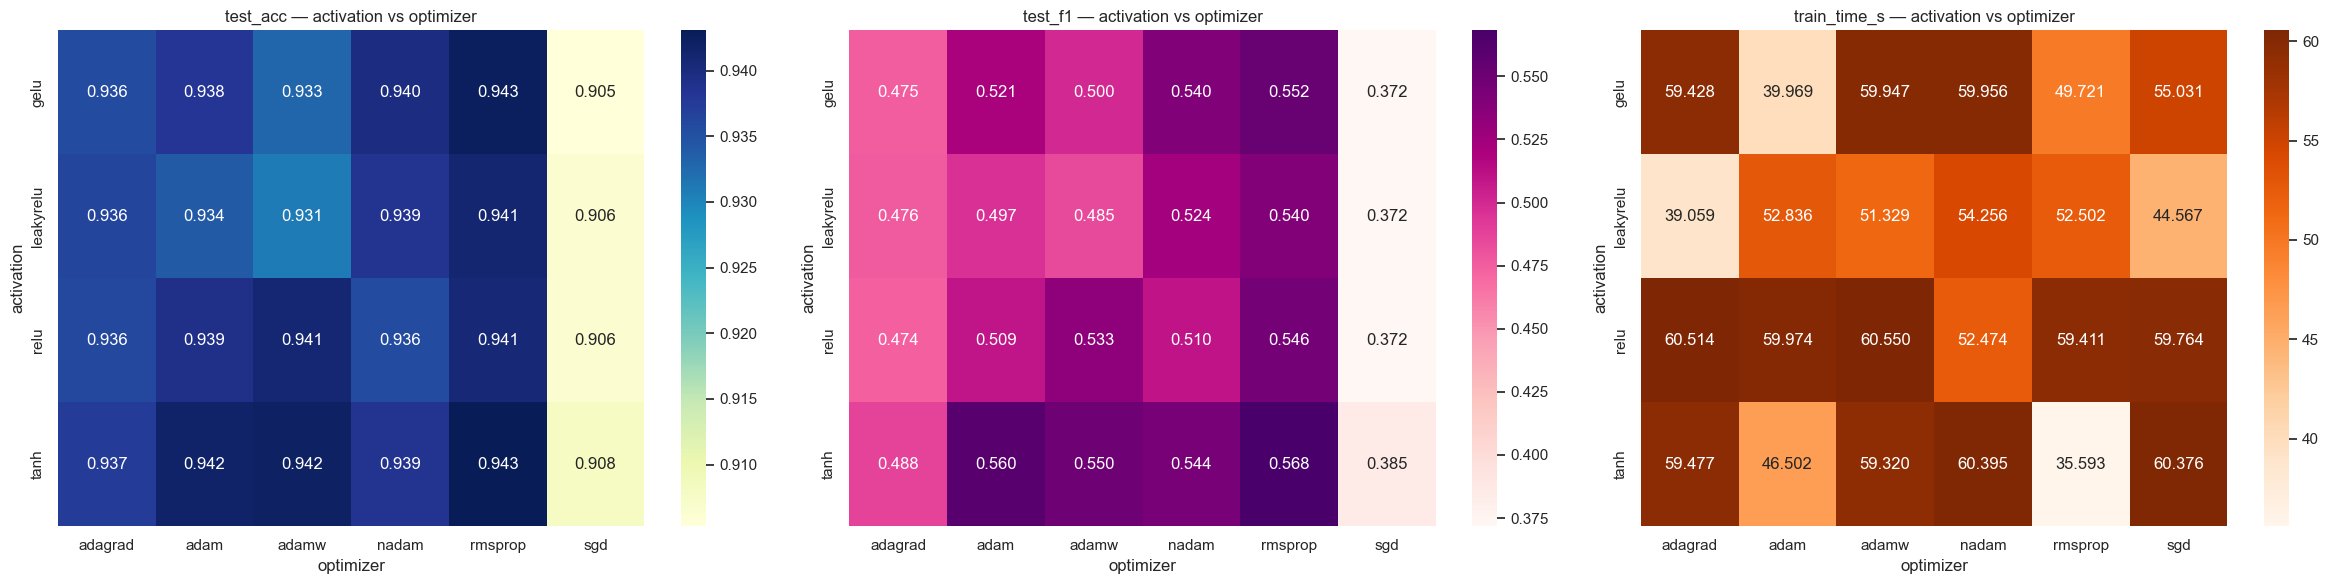

In [64]:
df = pd.read_csv("gru_grid_search_results_3.csv")

plots("activation", "optimizer")

## **Activation vs Optimizer**

### **1. Test Accuracy Patterns**

Across all activation functions, the optimizers **Adam**, **AdamW**, **Nadam**, **RMSProp**, and **Adagrad** consistently reach high accuracy (~0.93–0.94), while **SGD lags behind** for every activation (≈0.90–0.91).
Key observations:

* **RMSProp** gives the **highest accuracy overall**, performing especially well with *tanh* and *gelu*.
* **Tanh** is the top-performing activation on average, though *gelu* and *relu* are close behind.
* **SGD consistently underperforms**, confirming it is not competitive for this GRU setup.

**Conclusion:** Most optimizers except SGD perform similarly in accuracy, but **RMSProp + Tanh** is the best combination.

### **2. F1 Score Patterns**

The F1 score magnifies differences between optimizers and activations much more than accuracy:

* **Tanh clearly dominates**, achieving the best F1 scores with nearly every optimizer (up to ~0.56–0.57).
* **GELU and LeakyReLU underperform** relative to ReLU and Tanh.
* **RMSProp consistently delivers the strongest F1 scores** across all activations.
* **SGD again scores the lowest**, confirming its weakness for this dataset.

**Conclusion:** If class balance matters (which F1 captures), the best combination is **Tanh + RMSProp**, with **Adam**, **Nadam** and **AdamW** also performing well.

### **3. Training Time Patterns**

Training times vary meaningfully across optimizers:

* **Adam is consistently among the fastest optimizers**, especially with GELU and Tanh.
* **RMSProp has highly variable times** (fastest with Tanh, slow otherwise).
* **Adagrad, AdamW, and Nadam** tend to be **slower** and more consistent around ~59–60 seconds.
* **SGD is also relatively slow**, contradicting the usual expectation that it is lightweight.

**Conclusion:** For speed, **Adam** is the clear winner, while **Adagrad, AdamW, and Nadam** are the slowest. RMSProp can be very fast with certain activations (e.g., Tanh) but slower with others.

## **Overall Interpretation**

* **Best Trade-off (performance + stability):**
  **Tanh + RMSProp** — top accuracy, highest F1, sometimes fastest training.

* **Best for training speed:**
  **GELU/Tanh + Adam** — among the fastest combinations with strong accuracy and good F1.

* **Worst consistent performer:**
  **SGD**, both in accuracy and F1.

* **Activation Ranking (Overall):**
  **1. Tanh**
  **2. ReLU**
  **3. GELU**
  **4. LeakyReLU**

* **Optimizer Ranking (Overall):**
  **1. RMSProp**
  **2. Adam / AdamW / Nadam (tie)**
  **3. Adagrad**
  **4. SGD**

### **Final Takeaway:**

Moving forward, it seems like the best activation-optimizer pair is **Tanh-RMSProp**.


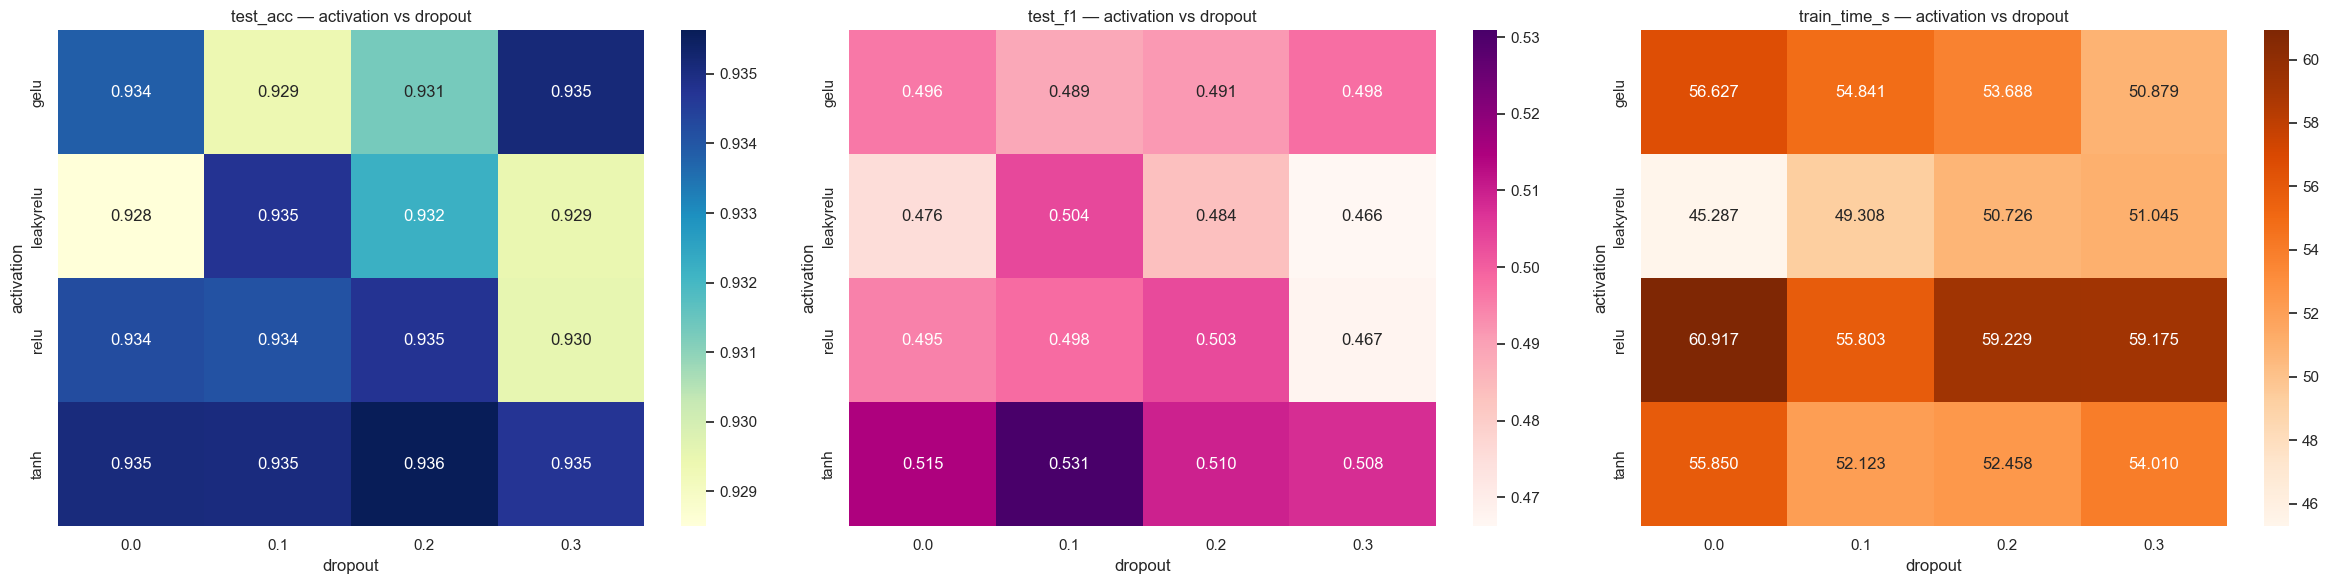

In [65]:
plots("activation", "dropout")

## **Activation vs Dropout**

### **1. Test Accuracy Patterns**

Accuracy is relatively stable across dropout levels, but a few trends appear:

* **Tanh consistently achieves the highest accuracy**, regardless of dropout level (≈0.935–0.936).
* **ReLU is the second most stable**, showing minimal variation except a slight drop at 0.3.
* **GELU and LeakyReLU fluctuate more**, with LeakyReLU in particular being inconsistent across dropout levels.
* Dropout **0.2–0.3 neither significantly improves nor hurts** accuracy in most cases.

**Conclusion:** Dropout has **little effect on accuracy**, but the most reliable activation is **Tanh**, followed by **ReLU**. LeakyReLU is the most unstable.

### **2. F1 Score Patterns**

F1 scores reveal more meaningful differences than accuracy:

* **Tanh again clearly performs the best** across nearly all dropout levels, especially with **0.1 dropout** (≈0.531 — the highest overall).
* **ReLU performs well up until 0.2 dropout**, but drops sharply at 0.3.
* **GELU is very stable**, but its F1 values remain slightly below ReLU/Tanh.
* **LeakyReLU is unstable**, improving with 0.1 dropout but dropping significantly at 0.3.

**Conclusion:**
The best combination is **Tanh + 0.1 dropout**, which yields the **highest F1 score overall**.
ReLU also benefits from moderate dropout (≈0.1–0.2), while LeakyReLU is inconsistent.

### **3. Training Time Patterns**

Training time shows more noticeable trends:

* **GELU speeds up consistently as dropout increases**, with ≈6 seconds difference from 0.0 → 0.3.
* **Tanh also becomes slightly faster** with moderate dropout, dropping from ~55s to ~52s.
* **ReLU is consistently the slowest activation**, with all dropout values above ~55 seconds.
* **LeakyReLU is generally the fastest**, especially at 0.0 dropout (≈45s), but becomes slower at higher dropout.

**Conclusion:**
If training speed matters:

* **LeakyReLU + low dropout** is fastest.
* **GELU + higher dropout** also reduces training time.
* **ReLU is consistently the slowest**, regardless of dropout.

## **Overall Interpretation**

* **Best performance (accuracy + F1):**
  **Tanh**, especially with **0.1 dropout**.

* **Most stable across dropout:**
  **Tanh > ReLU > GELU > LeakyReLU**

* **Effect of dropout on performance:**
  Dropout **barely affects accuracy**, but **0.1 dropout improves F1** for most activations.

* **Effect of dropout on speed:**
  More dropout generally → slightly faster training (especially for GELU and Tanh).

### **Final Takeaway:**

Moving forward, **Tanh with 0.1 dropout** seems the most promising, offering the best trade-off between accuracy, generalization, and training stability.


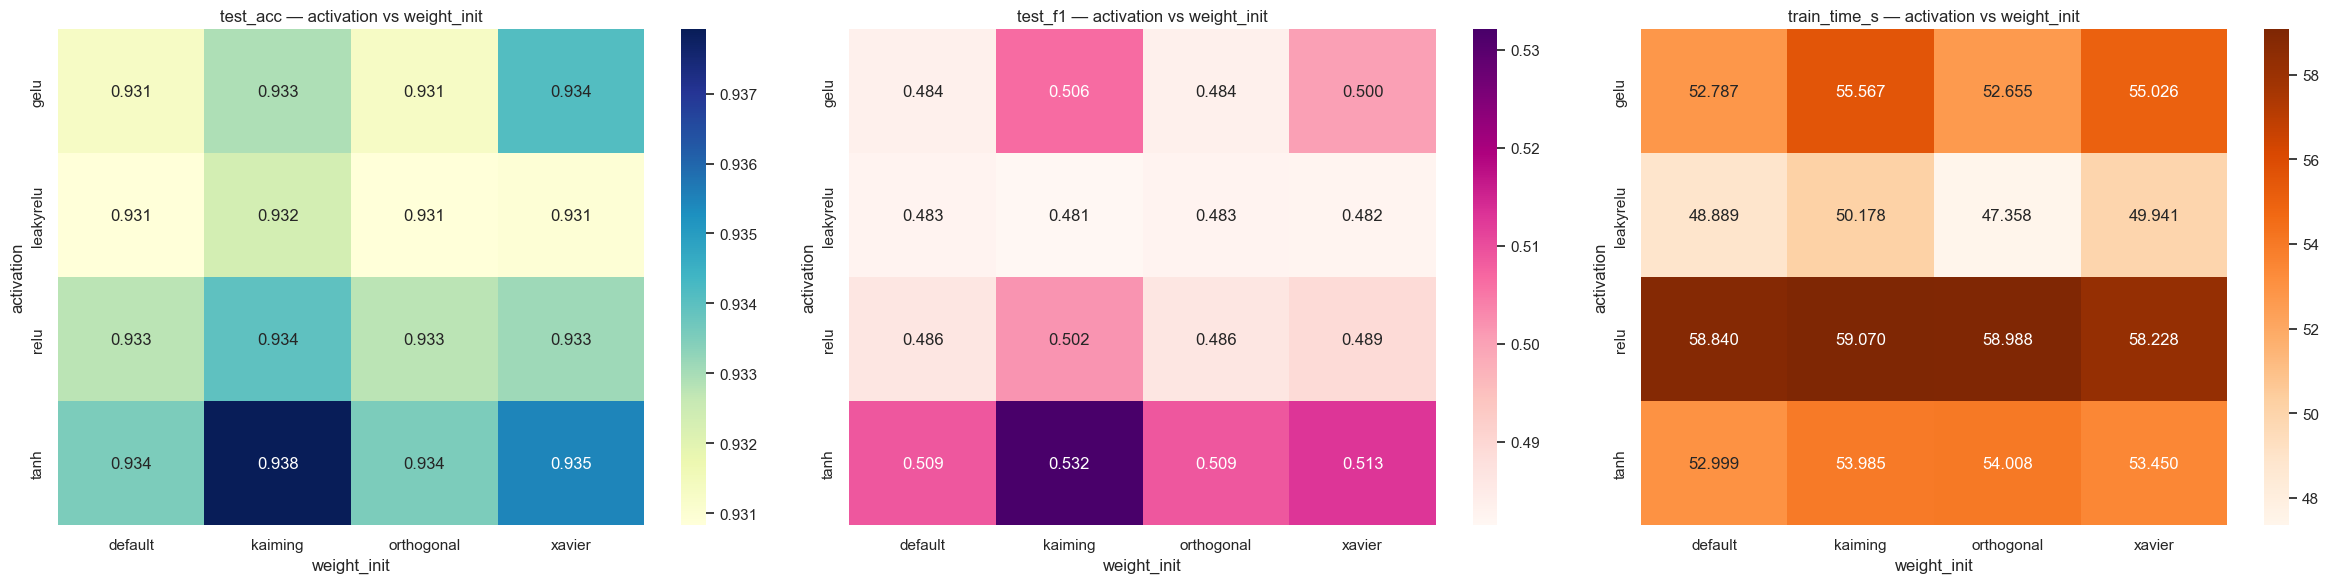

In [66]:
plots("activation", "weight_init")

## **Activation vs Weight Initialization**

### **1. Test Accuracy Patterns**

* **Tanh with Kaiming initialization achieves the highest accuracy** (≈0.938), followed closely by Tanh + Xavier (≈0.936).
* **ReLU also benefits from Kaiming**, but slightly less (≈0.934).
* GELU and LeakyReLU show minor differences across weight initializations, with **Xavier slightly better for GELU**.
* **Default and Orthogonal initializations generally perform slightly worse** across most activations.

**Conclusion:**
**Tanh is the most effective activation**, and **Kaiming or Xavier initialization slightly improves accuracy**.

### **2. F1 Score Patterns**

* F1 scores mirror accuracy trends.
* **Tanh + Kaiming gives the best F1** (≈0.532), followed by Tanh + Xavier (≈0.513).
* GELU and ReLU benefit moderately from Kaiming or Xavier.
* LeakyReLU is largely insensitive to initialization, hovering around ≈0.48.

**Conclusion:**
**Tanh combined with Kaiming initialization maximizes F1 score**, improving generalization slightly over other combinations.

### **3. Training Time Patterns**

* Training time is **relatively stable across weight initializations**, but minor differences exist:

  * GELU and Tanh: slightly faster with Default or Orthogonal (~52–53s) than Kaiming/Xavier (~55s).
  * ReLU: consistently slow (~58–59s).
  * LeakyReLU: fastest (~47–50s) and least affected by initialization.

**Conclusion:**
Weight initialization **does not strongly affect training time**, but there is a slight increase for Kaiming/Xavier compared to Default/Orthogonal.

## **Overall Interpretation**

* **Best combination for performance:**
  **Tanh + Kaiming** → highest test accuracy and F1.

* **Training time consideration:**
  LeakyReLU is fastest, but performance is weaker.

* **Effect of weight initialization:**
  Kaiming or Xavier slightly improve metrics for GELU, ReLU, and Tanh, while Default/Orthogonal are slightly slower or less performant.

### **Final Takeaway:**

Moving on, **fixing Tanh as the activation and Kaiming for weight initialization** seem like the best choice.


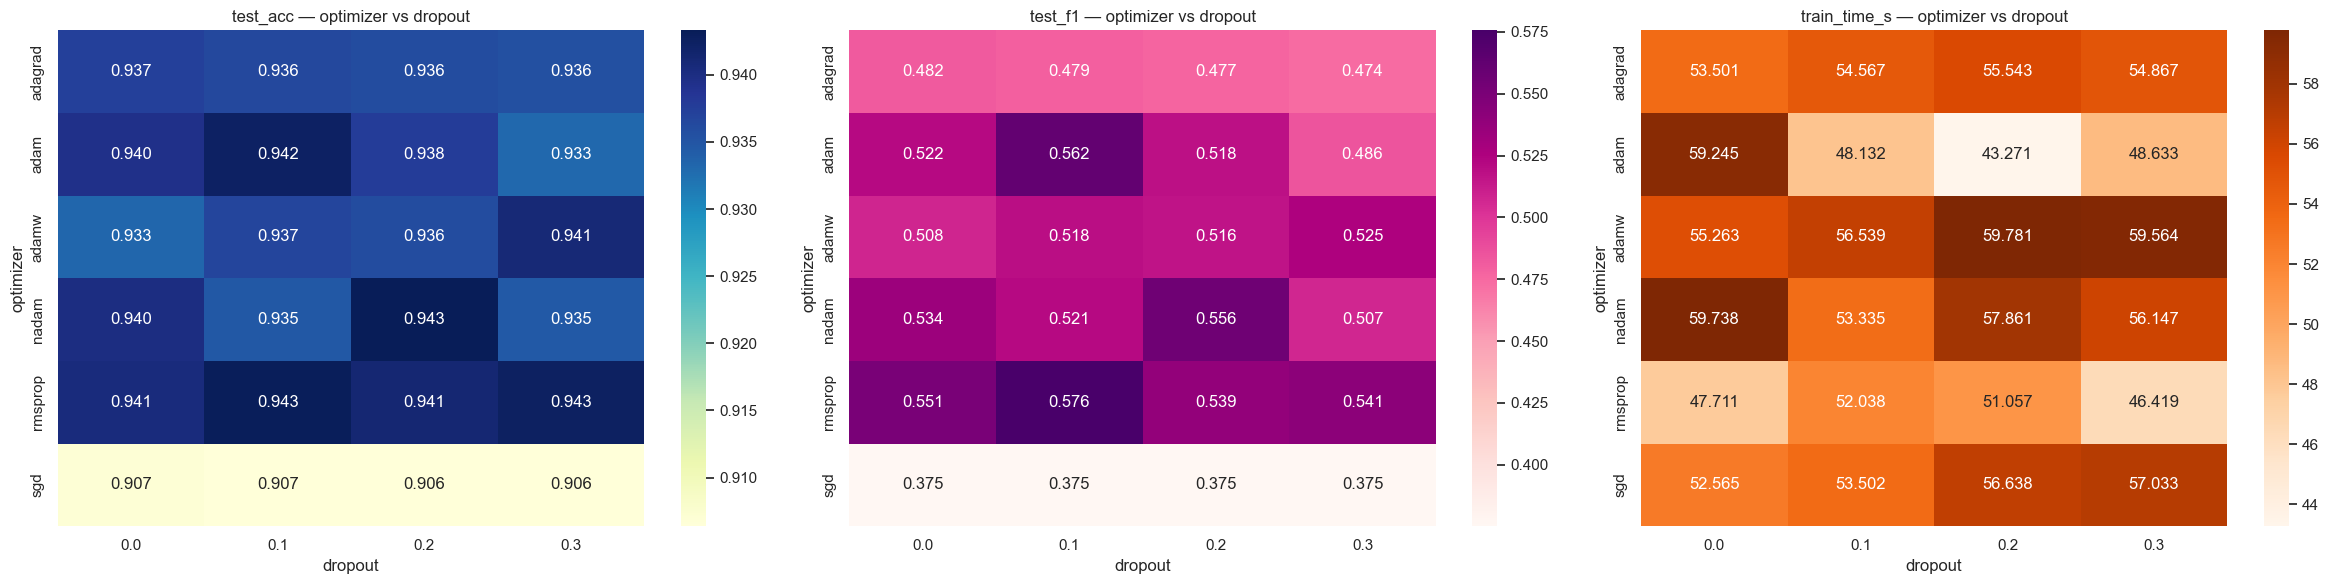

In [67]:
plots("optimizer", "dropout")

## **Optimizer vs Dropout**

### **1. Test Accuracy Patterns**

* **RMSprop performs consistently well** across all dropout rates (≈0.940–0.943).
* **Adam shows peak accuracy at 0.1 dropout** (0.942) but declines with higher dropout.
* AdamW and Nadam are less consistent, with AdamW showing improvement at higher dropout (0.3), Nadam peaking at 0.2.
* SGD consistently underperforms (≈0.906), unaffected by dropout.
* Adagrad is stable but slightly lower than Adam/RMSprop.

**Conclusion:**
**RMSprop and Adam are the most reliable optimizers for test accuracy**, while SGD is clearly inferior. Dropout has minor influence on accuracy except for Adam, where moderate dropout (0.1) is beneficial.

### **2. F1 Score Patterns**

* **RMSprop achieves the highest F1 scores**, peaking at 0.576 for 0.1 dropout.
* Adam benefits from moderate dropout (0.1) with F1 = 0.562.
* Nadam peaks at dropout 0.2 (0.556), AdamW at 0.3 (0.525).
* SGD remains the weakest across all dropout values (≈0.375).

**Conclusion:**
**RMSprop is the best optimizer for balanced class performance**, while Adam can also perform very well with moderate dropout. SGD is unsuitable.

### **3. Training Time Patterns**

* RMSprop is **fastest overall** (≈46–52s), with minor variance across dropout.
* Adam’s training time **decreases with higher dropout** (59 → 43s at 0.2) due to reduced gradient updates.
* AdamW and Nadam are slower (~55–60s).
* Adagrad and SGD are intermediate (~53–57s).

**Conclusion:**
**RMSprop is not only high-performing but also efficient**. Adam is moderately efficient, while AdamW/Nadam are slower.

### **Overall Interpretation**

* **Best overall optimizer:** RMSprop → high test accuracy, high F1, and low training time.
* **Best dropout setting (for Adam-type optimizers):** 0.1.
* **Optimizer to avoid:** SGD → poor performance across all dropout values.

**Final Takeaway:**
**RMSprop with dropout 0.1** is recommended moving forward, balancing accuracy, F1, and training efficiency.


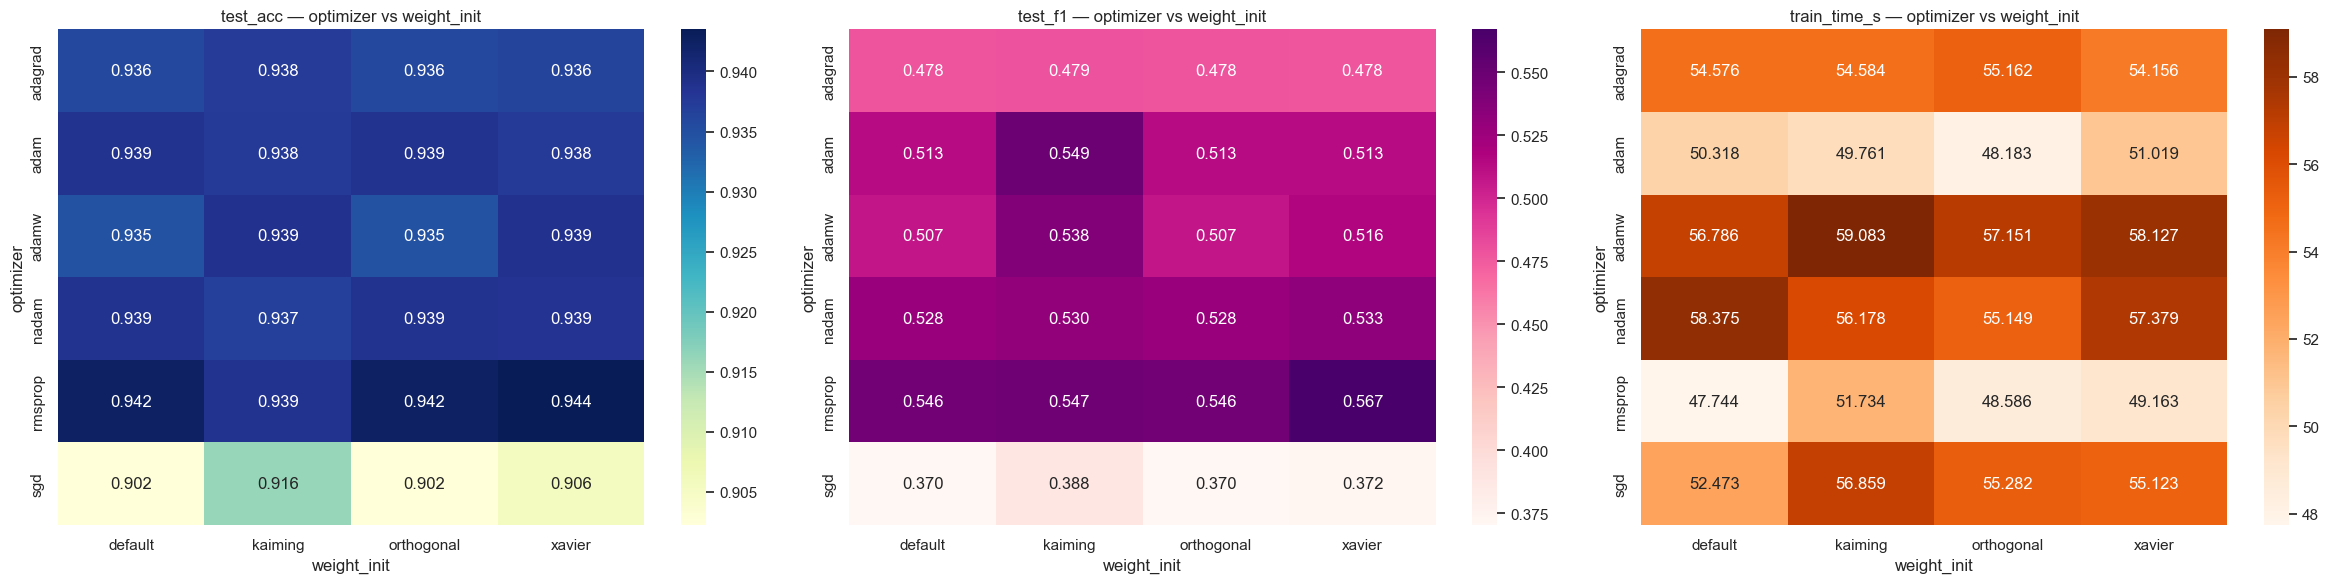

In [68]:
plots("optimizer", "weight_init")

## **Optimizer vs Weight Initialization**

### **1. Test Accuracy Patterns**

* **RMSprop again performs best**, with highest accuracy using Xavier initialization (0.9435) and strong results across all inits (0.9425–0.9435).
* Adam is consistently strong (~0.9377–0.9387) and stable across different initializations.
* AdamW and Nadam show moderate variation depending on weight initialization, with AdamW performing best with Kaiming/Xavier.
* SGD is the weakest, but Kaiming improves it slightly (0.916).
* Adagrad performs reasonably well, but slightly below Adam/RMSprop.

**Conclusion:**
RMSprop is highly robust to weight initialization, while SGD is sensitive and generally poor. Adam is reliable across all weight initializations.

### **2. F1 Score Patterns**

* RMSprop again dominates (~0.546–0.567), showing best performance with Xavier initialization.
* Adam’s F1 improves noticeably with Kaiming initialization (0.5494).
* AdamW and Nadam benefit from Kaiming/Xavier in some cases (~0.538–0.532).
* SGD remains poor (<0.39).
* Adagrad is stable but low (~0.478).

**Conclusion:**
**RMSprop with Xavier initialization achieves the best balance across classes.** Adam benefits from Kaiming, but performance difference is smaller compared to RMSprop.

### **3. Training Time Patterns**

* RMSprop is **fast and efficient** (≈47–49s), regardless of weight initialization.
* Adam is slightly slower (~48–51s), but stable.
* AdamW and Nadam are consistently the slowest (~55–59s).
* SGD and Adagrad are moderate (~52–55s).

**Conclusion:**
RMSprop is the **fastest high-performing optimizer**, further supporting its selection. Adam is acceptable in speed. AdamW/Nadam are less efficient.

### **Overall Interpretation**

* **Best optimizer/weight_init combo:** RMSprop + Xavier → highest accuracy, highest F1, and efficient training.
* Adam is a good alternative, especially with Kaiming initialization.
* SGD should be avoided; Adagrad is safe but not optimal.
* **Weight initialization matters more for some optimizers** (AdamW, Adam, Nadam) than others (RMSprop).

**Final Takeaway:**

**RMSprop with Xavier or Adam with Kaiming initialization** would be strong candidates to pair with chosen hidden size and learning rate.


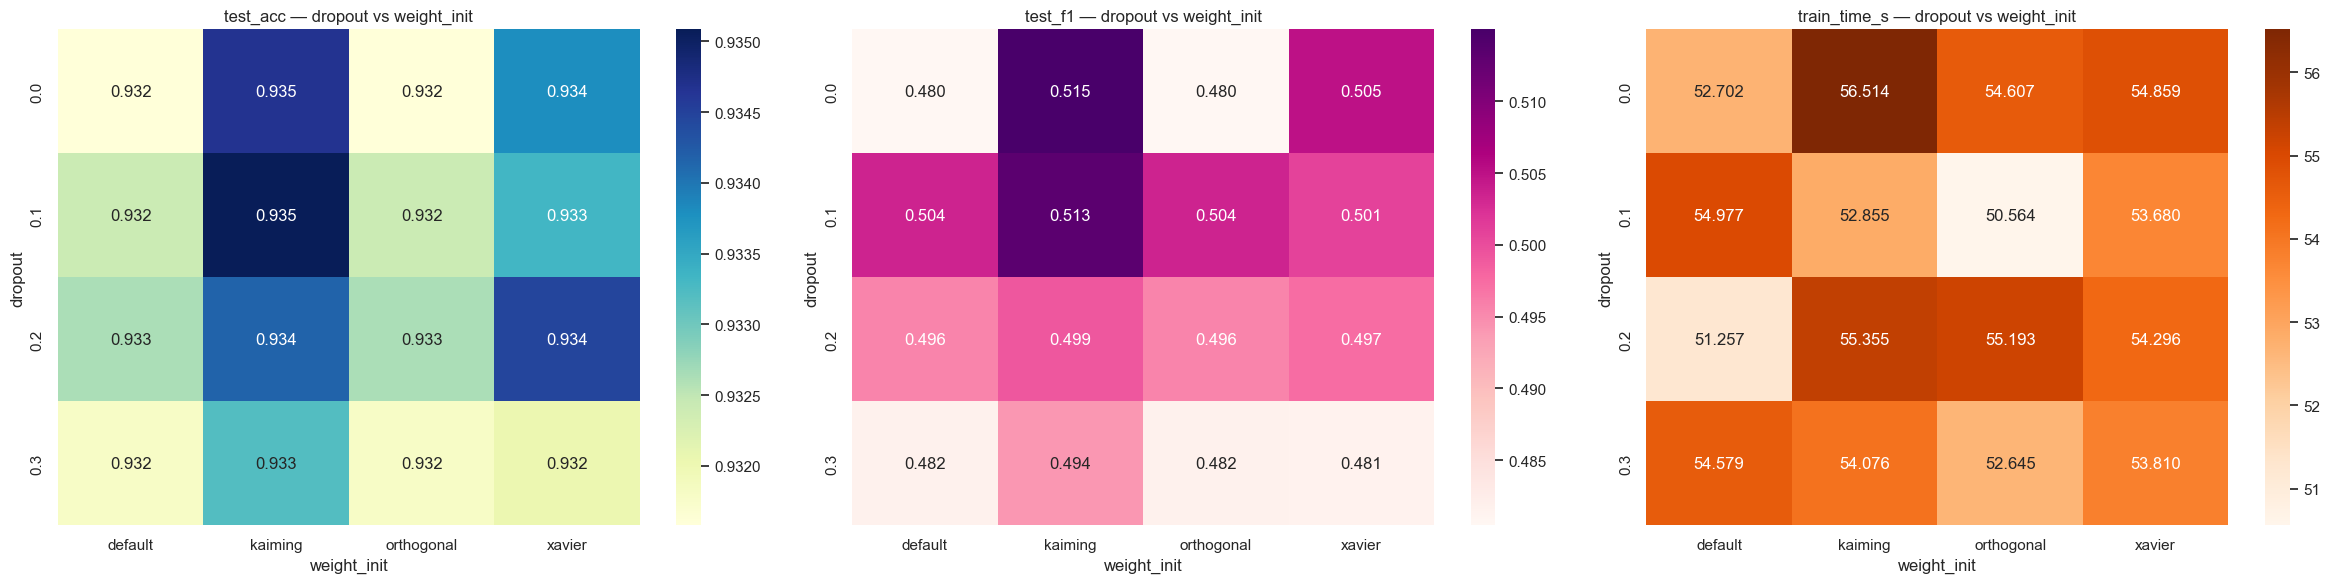

In [69]:
plots("dropout", "weight_init")

## **Dropout vs Weight Initialization**

### **1. Test Accuracy Patterns**

* Accuracy is generally **stable across dropout rates** (0.931–0.935), showing that small variations in dropout do not drastically affect overall performance.
* Kaiming initialization consistently gives slightly higher accuracy across all dropout rates (~0.933–0.935), with Xavier close behind.
* Default and Orthogonal inits perform a bit worse (~0.931–0.933).

**Conclusion:**
Accuracy is **mostly insensitive to dropout** within the tested range, but Kaiming initialization is a slight winner overall.

### **2. F1 Score Patterns**

* F1 scores vary more noticeably with dropout.
* Kaiming gives consistently high F1 (~0.494–0.515), with 0.0–0.1 dropout performing best.
* Xavier is generally strong (~0.500–0.505).
* Default and Orthogonal are lower (~0.480–0.503).
* Higher dropout (0.3) tends to **reduce F1**, especially for Default and Orthogonal.

**Conclusion:**
**Moderate dropout (0.0–0.2) is best** for maintaining F1. Kaiming initialization consistently boosts class-wise performance.

### **3. Training Time Patterns**

* Training times are **fairly consistent**, ranging roughly 50–56s.
* No strong interaction between dropout and weight initialization for speed, though some minor variations exist.

**Conclusion:**
Training time is largely **unaffected by dropout or weight initialization** in this range.

### **Overall Interpretation**

* **Best combo for generalization:** Kaiming initialization with 0.0–0.1 dropout → high F1 and competitive accuracy.
* Dropout >0.2 provides little benefit and may slightly reduce class-wise performance.
* Accuracy is relatively insensitive to dropout; F1 highlights subtle differences.

**Final Takeaway:**
From now on, the best bet might be to use **Kaiming initialization and a low dropout (0.0–0.1)** to maximize both accuracy and F1 without increasing training time by a lot.
